In [1]:
#installing library dash for the web app
!pip install dash

#Imports

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import warnings
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import SequentialFeatureSelector

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.exceptions import UndefinedMetricWarning
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, explained_variance_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import ExtraTreesRegressor
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

C:\Users\DELL\AppData\Local\Temp\ipykernel_4136\3355167644.py:7: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`
  import dash_core_components as dcc
C:\Users\DELL\AppData\Local\Temp\ipykernel_4136\3355167644.py:8: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html


# The dataset




The dataset was constructed using an open-source dataset titled "BigSolDB: Solubility Dataset of Compounds in Organic Solvents and Water in a Wide Range of Temperatures." This dataset contains 54,273 experimental solubility values across a temperature range of 243.15 to 403.15 K in various organic solvents and water. In the final stages of dataset creation, we employed the RDKit, a powerful cheminformatics and machine learning library. RDKit facilitates the computation and manipulation of chemical information, allowing us to fill in additional attributes such as molecular weight, number of hydrogen donors, number of rings, number of rotatable bonds, and polar surface area through machine learning techniques.

In [3]:
file_path = 'Dataset/SolubiltyDB.csv'

# Specify column names manually
columns = ["SMILES", "T,K", "Solubility", "Solvent", "SMILES_Solvent", "Source", "Molecular Weight", "Number of H-Bond Donors", "Number of Rings", "Number of Rotatable Bonds", "Polar Surface Area"]
# Read the CSV file into a DataFrame with the specified column names
df = pd.read_csv(file_path, names=columns, skiprows=1)

# Suppress FutureWarning for numeric_only in DataFrame.corr
warnings.simplefilter(action='ignore', category=FutureWarning)
# Display the DataFrame
df.head()

,SMILES,"T,K",Solubility,Solvent,SMILES_Solvent,Source,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area
0,ON(Cc1ccccc1)Cc1ccccc1,273.15,0.001261,methanol,CO,10.1021/acs.jced.9b01028,213.28,1.0,2.0,4.0,23.47
1,ON(Cc1ccccc1)Cc1ccccc1,279.15,0.001713,methanol,CO,10.1021/acs.jced.9b01028,213.28,1.0,2.0,4.0,23.47
2,ON(Cc1ccccc1)Cc1ccccc1,283.45,0.002094,methanol,CO,10.1021/acs.jced.9b01028,213.28,1.0,2.0,4.0,23.47
3,ON(Cc1ccccc1)Cc1ccccc1,289.05,0.002760,methanol,CO,10.1021/acs.jced.9b01028,213.28,1.0,2.0,4.0,23.47
4,ON(Cc1ccccc1)Cc1ccccc1,293.05,0.003327,methanol,CO,10.1021/acs.jced.9b01028,213.28,1.0,2.0,4.0,23.47


In [4]:
#dropping the source column
df = df.drop(['Source'],axis=1)
#printing the number of instances and attributes
print('Number of instances = %d' % (df.shape[0]))
print('Number of attributes = %d' % (df.shape[1]))
#the number of unique smiles in the dataset
unique_smiles_count = df['SMILES'].nunique()

#the number of unique solvent in the dataset
unique_solvents_count = df['Solvent'].nunique()
# Print the results
print(f"Number of unique SMILES: {unique_smiles_count}")
print(f"Number of unique solvents: {unique_solvents_count}")

Number of instances = 54273
Number of attributes = 10
Number of unique SMILES: 2386
Number of unique solvents: 128


In [5]:
unique_smiles_df = df.drop_duplicates(subset='SMILES', keep='first')
unique_smiles_df.head()


,SMILES,"T,K",Solubility,Solvent,SMILES_Solvent,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area
0,ON(Cc1ccccc1)Cc1ccccc1,273.15,0.001261,methanol,CO,213.280,1.0,2.0,4.0,23.47
11,COC(=O)[C@@H](N)CS.Cl,283.15,0.090610,methanol,CO,171.649,2.0,0.0,2.0,52.32
22,CC1(C)NC(=O)NC1=O,283.15,0.064720,methanol,CO,128.131,2.0,1.0,0.0,58.20
31,NS(=O)(=O)Cc1noc2ccccc12,273.15,0.002534,methanol,CO,212.230,1.0,2.0,2.0,86.19
40,CC(=O)Oc1ccccc1C(=O)Nc1ncc([N+](=O)[O-])s1,273.15,0.000103,methanol,CO,307.287,1.0,2.0,4.0,111.43


# Cleaning the dataset


In [6]:
#printing the missing values
print('Number of missing values:')
for col in df.columns:
    print('\t%s: %d' % (col,df[col].isna().sum()))

Number of missing values:
	SMILES: 0
	T,K: 1556
	Solubility: 1556
	Solvent: 1556
	SMILES_Solvent: 1556
	Molecular Weight: 1556
	Number of H-Bond Donors: 1556
	Number of Rings: 1556
	Number of Rotatable Bonds: 1556
	Polar Surface Area: 1556


In [7]:
# Identify rows with missing values
missing_rows = df[df.isnull().any(axis=1)]

# Print SMILES values for rows with missing values
print("SMILES values for rows with missing values:")
print(missing_rows['SMILES'])

print('Percentage of missing values:')
total_instances = df.shape[0]

for col in df.columns:
    missing_percentage = (df[col].isna().sum() / total_instances) * 100
    print('\t%s: %.2f%%' % (col, missing_percentage))



SMILES values for rows with missing values:
31859    ON(Cc1ccccc1)Cc1ccccc1,273.15,0.003426,"1,2-di...
31860    ON(Cc1ccccc1)Cc1ccccc1,279.15,0.004858,"1,2-di...
31861    ON(Cc1ccccc1)Cc1ccccc1,283.65,0.006239,"1,2-di...
31862    ON(Cc1ccccc1)Cc1ccccc1,289.15,0.008596,"1,2-di...
31863    ON(Cc1ccccc1)Cc1ccccc1,293.25,0.01059,"1,2-dic...
                               ...                        
54204    NCCCC(=O)O,303.15,0.009136,"1,3-propanediol",O...
54205    NCCCC(=O)O,308.15,0.0103,"1,3-propanediol",OCC...
54206    NCCCC(=O)O,313.15,0.01165,"1,3-propanediol",OC...
54207    NCCCC(=O)O,318.15,0.0135,"1,3-propanediol",OCC...
54208    NCCCC(=O)O,323.15,0.01494,"1,3-propanediol",OC...
Name: SMILES, Length: 1556, dtype: object
Percentage of missing values:
	SMILES: 0.00%
	T,K: 2.87%
	Solubility: 2.87%
	Solvent: 2.87%
	SMILES_Solvent: 2.87%
	Molecular Weight: 2.87%
	Number of H-Bond Donors: 2.87%
	Number of Rings: 2.87%
	Number of Rotatable Bonds: 2.87%
	Polar Surface Area: 2.87%


we dropped the missing values because they represent 2.87% of the whole dataset


In [8]:
# Drop rows with missing values
df_cleaned = df.dropna()

print('Number of rows in original data = %d' % (df.shape[0]))
print('Number of rows after discarding missing values = %d' % (df_cleaned.shape[0]))

Number of rows in original data = 54273
Number of rows after discarding missing values = 52717


In [9]:
# Identify rows with identical values in the specified columns
duplicated_rows = df[df.duplicated(subset=['SMILES', 'T,K', 'Solubility', 'Solvent', 'Molecular Weight', 'Number of H-Bond Donors', 'Number of Rings', 'Number of Rotatable Bonds', 'Polar Surface Area'], keep='first')]

percentage_duplicated = (len(duplicated_rows) / total_instances) * 100
print(f"Percentage of duplicated rows: {percentage_duplicated:.2f}%")


Percentage of duplicated rows: 1.23%


we dropped the duplicated values since they represent 1.23% of the whole dataset

In [10]:
print('Number of rows before discarding duplicates = %d' % (df_cleaned.shape[0]))
df_cleaned = df_cleaned.drop_duplicates()
print('Number of rows after discarding duplicates = %d' % (df_cleaned.shape[0]))

Number of rows before discarding duplicates = 52717
Number of rows after discarding duplicates = 52047


In [11]:
#the number of unique smiles in the dataset
unique_smiles_count = df_cleaned['SMILES'].nunique()

#the number of unique solvent in the dataset
unique_solvents_count = df_cleaned['Solvent'].nunique()
# Print the results
print(f"Number of unique SMILES: {unique_smiles_count}")
print(f"Number of unique solvents: {unique_solvents_count}")

df_original=df_cleaned

Number of unique SMILES: 830
Number of unique solvents: 128


In [12]:
import string

def detect_special_characters(data):
    special_characters = set(string.punctuation)

    # Check for special characters in each column
    for column in data.columns:
        special_chars_in_column = set("".join(str(data[column])))
        detected_special_chars = special_chars_in_column.intersection(special_characters)

        if detected_special_chars:
            print(f"Special characters found in column '{column}': {detected_special_chars}")

#detecting special characters in our dataframe
detect_special_characters(df_cleaned)


Special characters found in column 'SMILES': {'(', '=', ')', ',', '.', ':'}
Special characters found in column 'T,K': {',', ':', '.'}
Special characters found in column 'Solubility': {',', ':', '.'}
Special characters found in column 'Solvent': {',', ':', '.'}
Special characters found in column 'SMILES_Solvent': {'(', '=', '_', ')', ',', '.', ':'}
Special characters found in column 'Molecular Weight': {',', ':', '.'}
Special characters found in column 'Number of H-Bond Donors': {',', ':', '-', '.'}
Special characters found in column 'Number of Rings': {',', ':', '.'}
Special characters found in column 'Number of Rotatable Bonds': {',', ':', '.'}
Special characters found in column 'Polar Surface Area': {',', ':', '.'}


In [13]:
#invalid smiles indices in our dataset
invalid_smiles_indices = df_cleaned[df_cleaned["SMILES_Solvent"] == "-"]
print(invalid_smiles_indices)

                                                  SMILES     T,K  Solubility  \
53460           CN1C(C(=O)Nc2ccccn2)=C(O)c2sccc2S1(=O)=O  298.15    0.009760   
53461           CN1C(C(=O)Nc2ccccn2)=C(O)c2sccc2S1(=O)=O  303.15    0.013100   
53462           CN1C(C(=O)Nc2ccccn2)=C(O)c2sccc2S1(=O)=O  308.15    0.017500   
53463           CN1C(C(=O)Nc2ccccn2)=C(O)c2sccc2S1(=O)=O  313.15    0.022700   
53464           CN1C(C(=O)Nc2ccccn2)=C(O)c2sccc2S1(=O)=O  323.15    0.034500   
53465                                  O=C1Nc2ccccc2C1=O  298.15    0.098500   
53466                                  O=C1Nc2ccccc2C1=O  308.15    0.109000   
53467                                  O=C1Nc2ccccc2C1=O  318.15    0.121000   
53468                                  O=C1Nc2ccccc2C1=O  328.15    0.132000   
53469                                  O=C1Nc2ccccc2C1=O  338.15    0.144000   
53470  COC(=O)[C@H]1[C@H]2C[C@@H]3c4[nH]c5cc(OC)ccc5c...  298.15    0.001440   
53471  COC(=O)[C@H]1[C@H]2C[C@@H]3c4[nH]

In [14]:
# Find rows where "Solvent" is equal to "peg400"
peg400_rows = df_cleaned[df_cleaned["Solvent"] == "PEG-400"]

# Specify the new SMILES for "peg400"
new_smiles_for_peg400 = "C(COCCOCCOCCOCCO)O"

# Update the "SMILES_Solvent" column for the rows where "Solvent" is "peg400"
df_cleaned.loc[peg400_rows.index, "SMILES_Solvent"] = new_smiles_for_peg400

peg200_rows = df_cleaned[df_cleaned["Solvent"] == "PEG-200"]

# Specify the new SMILES for "peg400"
new_smiles_for_peg200 = "CCCCCCCCCCCCCC=CC(C(COC(=O)CCC(=O)OCCOC)NC(=O)CCCCCCC)O"

# Update the "SMILES_Solvent" column for the rows where "Solvent" is "peg400"
df_cleaned.loc[peg200_rows.index, "SMILES_Solvent"] = new_smiles_for_peg200
# Find rows where "Solvent" is equal to "peg400"
peg300_rows = df_cleaned[df_cleaned["Solvent"] == "PEG-300"]

# Specify the new SMILES for "peg400"
new_smiles_for_peg300 = "COCCCCO.N"

# Update the "SMILES_Solvent" column for the rows where "Solvent" is "peg400"
df_cleaned.loc[peg300_rows.index, "SMILES_Solvent"] = new_smiles_for_peg300



In [15]:
invalid_smiles_indices = df_cleaned[df_cleaned["SMILES_Solvent"] == "-"]
print(invalid_smiles_indices)

Empty DataFrame
Columns: [SMILES, T,K, Solubility, Solvent, SMILES_Solvent, Molecular Weight, Number of H-Bond Donors, Number of Rings, Number of Rotatable Bonds, Polar Surface Area]
Index: []


# EDA

**scatter plot using the Matplotlib library, depicting the relationship between the molecular weight of compounds and their measured solubility.**

This scatter plot depict the relationship between the molecular weight of a given compound and it's measured solubility. from this plot we can observe the the density of the points is more high in the region where the molecular weight of the compound is smaller

In [16]:
df=df_cleaned

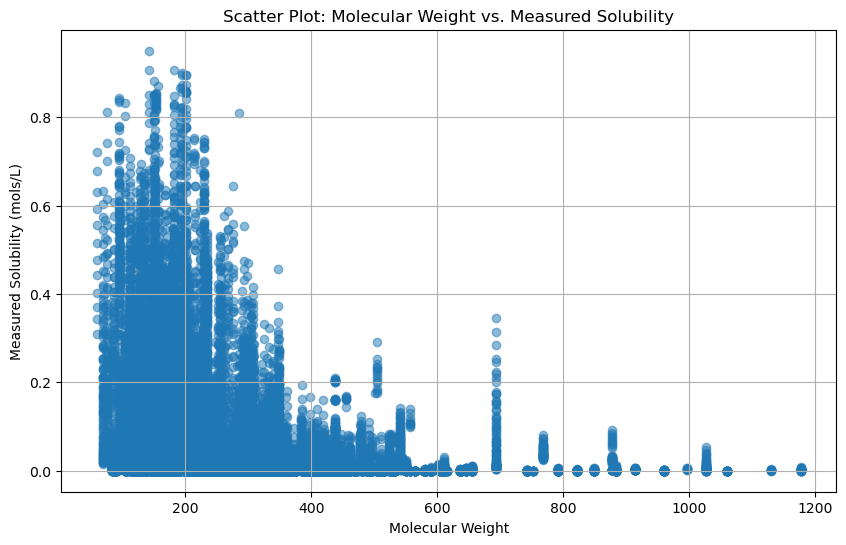

In [17]:
molecular_weight = df['Molecular Weight']
measured_solubility = df['Solubility']

# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(molecular_weight, measured_solubility, alpha=0.5)
plt.title('Scatter Plot: Molecular Weight vs. Measured Solubility')
plt.xlabel('Molecular Weight')
plt.ylabel('Measured Solubility (mols/L)')
plt.grid(True)
plt.show()

Now we create a web app that allows users to select a compound from the dropdown, and it dynamically updates the solubility chart based on the selected compound.
The chart displays solubility trends at different temperatures for various solvents, and the user can interact with the chart to explore the data.

In [18]:
# Select top 20 SMILES and top 10 solvents
top_smiles = df['SMILES'].value_counts().head(20).index
top_solvents = df['Solvent'].value_counts().head(10).index

df_filtered = df[(df['SMILES'].isin(top_smiles)) & (df['Solvent'].isin(top_solvents))]

# Initialize the Dash app
app = dash.Dash(__name__)

# Define the layout of the app
app.layout = html.Div([
    # Dropdown for selecting a compound
    dcc.Dropdown(
        id='compound-dropdown',
        options=[{'label': compound, 'value': compound} for compound in df_filtered['SMILES'].unique()],
        value=df_filtered['SMILES'].iloc[0],
        multi=False,
        style={'width': '50%'}
    ),
    # Graph for displaying the solubility chart
    dcc.Graph(id='solubility-chart')
])

# Define the callback to update the solubility chart based on the selected compound
@app.callback(
    Output('solubility-chart', 'figure'),
    [Input('compound-dropdown', 'value')]
)
def update_chart(selected_compound):
    filtered_data = df_filtered[df_filtered['SMILES'] == selected_compound]
    fig = px.line(filtered_data, x='T,K', y='Solubility', line_group='Solvent', color='Solvent',
                  labels={'T,K': 'Temperature (K)', 'Solubility': 'Solubility'},
                  title=f'Solubility Chart for {selected_compound}')
    return fig

# Run the app
if __name__ == '__main__':
    app.run_server(debug=True)

## **Explore The Top 50 of The Most Popular Solvents**
### This visualization presents the top 50 most prevalent solvents within the dataset. It aims to illustrate the distribution and frequency of these solvents, providing an immediate insight into the dataset's solvent composition and their significance in experimental records.

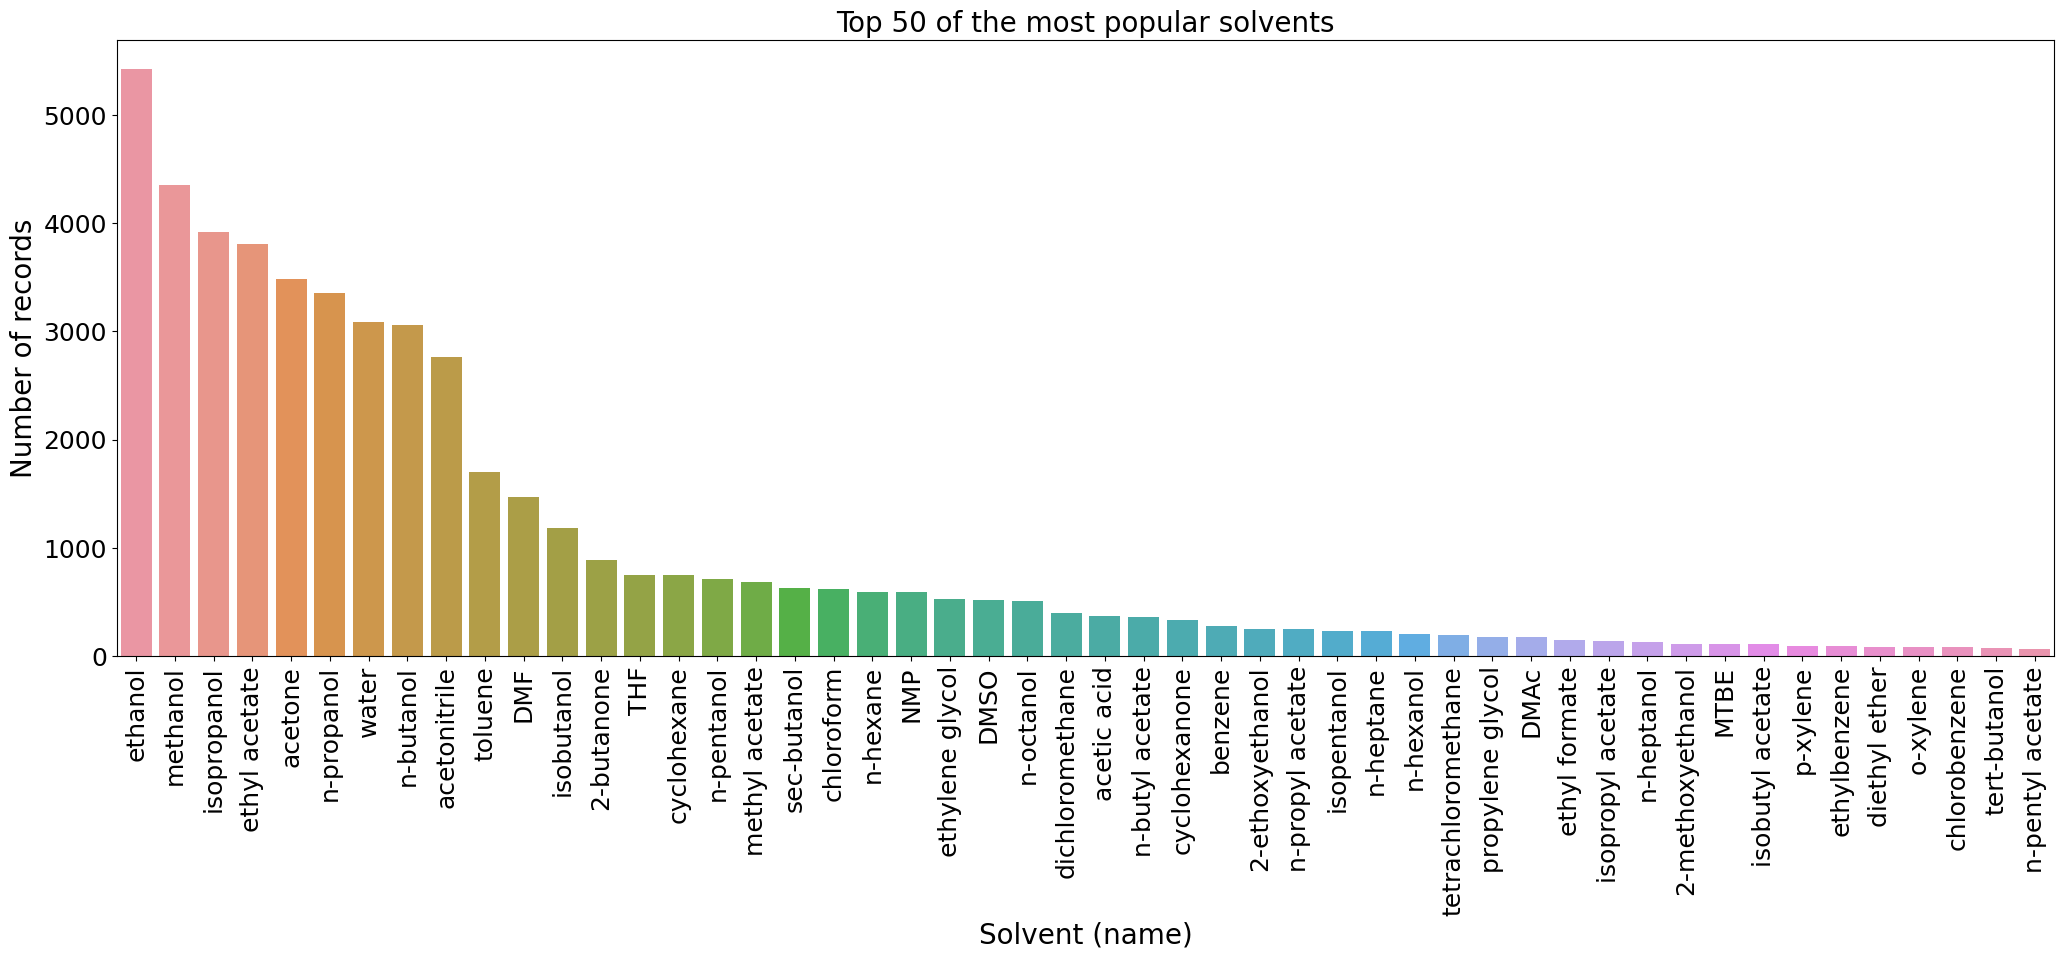

In [19]:
idx = df['Solvent'].value_counts()[:50].index
top_50_solvents = df[df['Solvent'].isin(idx)]

plt.figure(figsize=(25, 8))
sns.countplot(data=top_50_solvents, x='Solvent', order=top_50_solvents['Solvent'].value_counts().index)
plt.xticks(rotation=90)
plt.tick_params(labelsize=18)
plt.xlabel('Solvent (name)', fontsize=20)
plt.ylabel('Number of records', fontsize=20)
plt.title('Top 50 of the most popular solvents', fontsize=20)
plt.show()


In [20]:
#getting the top  50 solvents
top_50_solvents_counts = df_cleaned['Solvent'].value_counts().head(50)

# Calculate the total number of records in the dataset
top_50_solvents_total_records = top_50_solvents_counts.sum()
total_records=(df_cleaned.shape[0])

# Calculate the percentage of records for each solvent
percentage_records = (top_50_solvents_total_records / total_records) * 100


# Display the total percentage contribution of the top 50 solvents
print(f"Total percentage of the top 50 solvents: {percentage_records}%")



Total percentage of the top 50 solvents: 96.38211616423618%


In [21]:
# getting the top 50 solvents in the dataset
top_50_solvents_counts = df['Solvent'].value_counts().head(50)

# Calculate the total number of records in the dataset
total_records = top_50_solvents_counts.sum()

# Calculate the percentage of records for each solvent
percentage_records = (top_50_solvents_counts / total_records) * 100

# Calculate the total percentage of all the top 50 solvents
total_percentage = percentage_records.sum()

# Display the total percentage contribution of the top 50 solvents
print(f"Total percentage of the top 50 solvents: {total_percentage}%")

#total unique solvents
total_unique_solvents = df['Solvent'].nunique()

# Display the total number of unique solvents
print(f"Total number of unique solvents: {total_unique_solvents}")


Total percentage of the top 50 solvents: 100.0%
Total number of unique solvents: 128




## **Exploring the number of Unique Compounds Dissolved in the Top 50 Most Popular Solvents**




 Here in this section we are visualizing the distribution of unique compounds across the top 50 solvents, this countplot offers a snapshot of chemical diversity within the dataset. Each bar represents a solvent, showcasing the number of distinct compounds studied. Explore the prevalence and variety of compounds in different solvent environments.


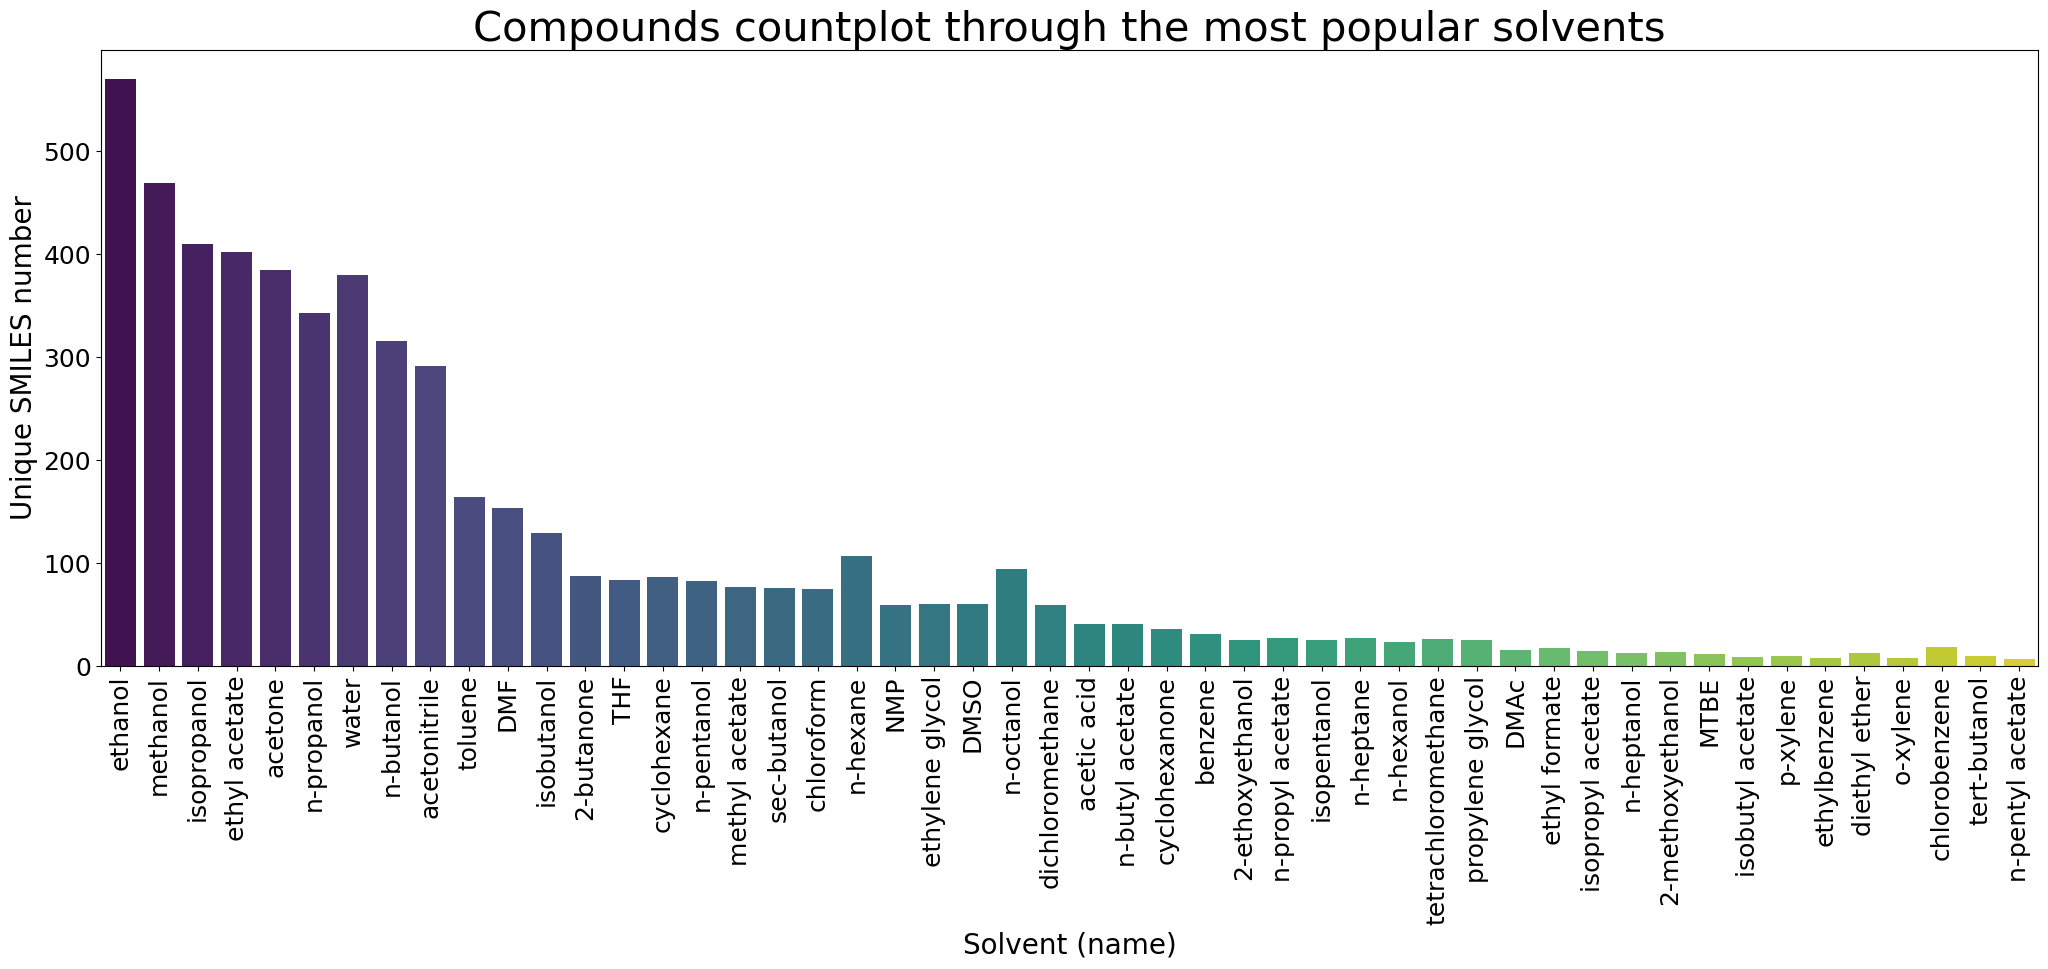

In [22]:

# Identify the 50 most popular solvents
top_50_solvents = df['Solvent'].value_counts().head(50).index

# Filter the dataset for the top 50 solvents
df_top_50_solvents = df[df['Solvent'].isin(top_50_solvents)]

# Count the number of unique compounds for each solvent
compound_counts_by_solvent = df_top_50_solvents.groupby('Solvent')['SMILES'].nunique().reset_index()

# Create a bar chart
plt.figure(figsize=(25, 8))
sns.barplot(x='Solvent', y='SMILES', data=compound_counts_by_solvent, order=top_50_solvents, palette='viridis')
plt.xticks(rotation=90)
plt.tick_params(labelsize=18)
plt.xlabel('Solvent (name)', fontsize=20)
plt.ylabel('Unique SMILES number', fontsize=20)
plt.title('Compounds countplot through the most popular solvents', fontsize=30)
plt.show()

## **Explore The Solubility Values**
#### The following analysis delves into the solubility distribution of compounds across various solvents. The dataset contains a comprehensive collection of experimental solubility values in diverse organic solvents and water.
The aim of this exploration is to visualize and compare the distribution of solubility values for the top 20 most prevalent solvents in the dataset. Each histogram represents the frequency distribution of solubility values within a specific solvent, providing insights into the solubility characteristics exhibited across these compounds.

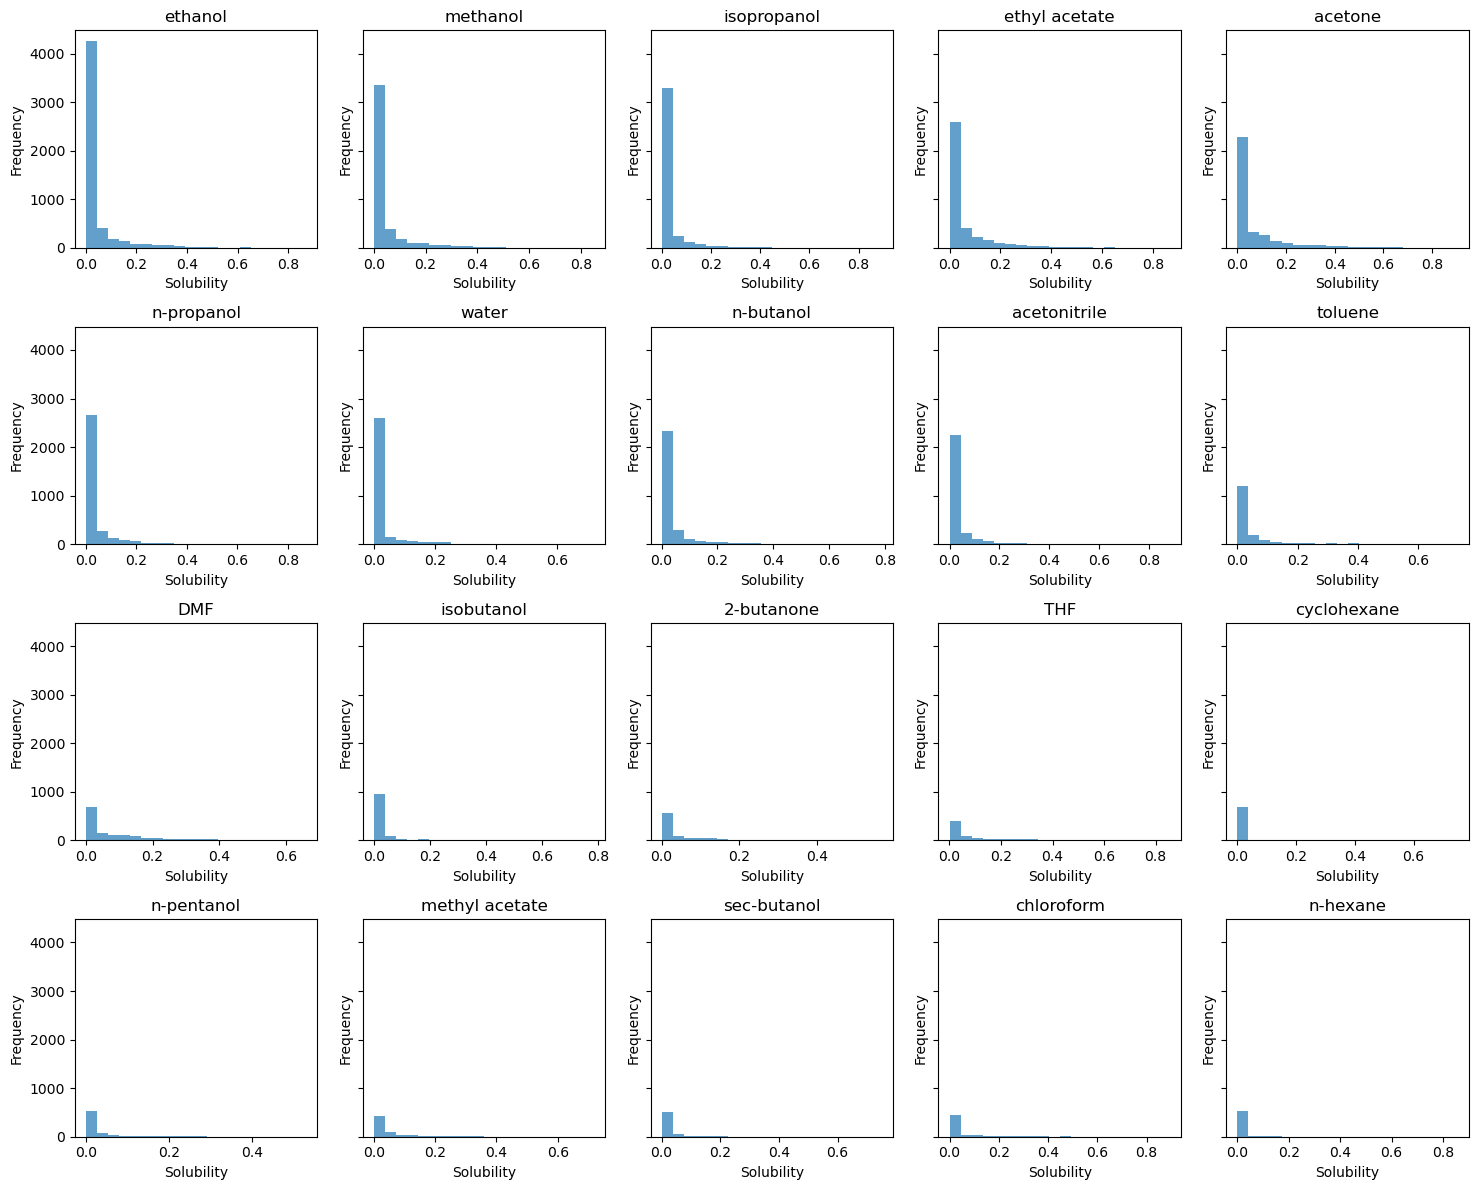

In [23]:
# Get the top 20 most popular solvents
top_20_solvents = df['Solvent'].value_counts().head(20).index.tolist()

# Filter the DataFrame for the top 10 solvents
df_top_20_solvents = df[df['Solvent'].isin(top_20_solvents)]

# Define the number of subplots and rows
num_plots = len(top_20_solvents)
num_rows = (num_plots + 4) // 5  # To get the number of rows needed

# Create subplots
fig, axes = plt.subplots(num_rows, 5, figsize=(15, 3 * num_rows), sharey=True)
axes = axes.flatten()

for i, solvent in enumerate(top_20_solvents):
    data_for_solvent = df_top_20_solvents[df_top_20_solvents['Solvent'] == solvent]
    axes[i].hist(data_for_solvent['Solubility'], bins=20, alpha=0.7)
    axes[i].set_title(f'{solvent}')
    axes[i].set_xlabel('Solubility')
    axes[i].set_ylabel('Frequency')

# Hide empty subplots if any
for j in range(i + 1, num_rows * 5):
    fig.delaxes(axes[j])

# Adjust layout and display
plt.tight_layout()
plt.show()

## **Explore Solubility Patterns in Top Solvents at the Most Popular Temperature**

In this section, we aim to create a heatmap that visually explores the patterns of solubilities measured in the 30 most popular solvents at the most frequently occurring temperature. This visualization will provide insights into how solubility varies across different solvents under the most common experimental conditions, aiding our understanding of the dataset's characteristics.

1.   **Find the 30 Most Popular Solvents**


In [24]:
# We will identify the 30 most frequently occurring solvents in the 'Solvent' column.

top30_solvents = df['Solvent'].value_counts().head(30).index

# Display the list of top solvents
print("Top Solvents:")
print(top30_solvents)

Top Solvents:
Index(['ethanol', 'methanol', 'isopropanol', 'ethyl acetate', 'acetone',
       'n-propanol', 'water', 'n-butanol', 'acetonitrile', 'toluene', 'DMF',
       'isobutanol', '2-butanone', 'THF', 'cyclohexane', 'n-pentanol',
       'methyl acetate', 'sec-butanol', 'chloroform', 'n-hexane', 'NMP',
       'ethylene glycol', 'DMSO', 'n-octanol', 'dichloromethane',
       'acetic acid', 'n-butyl acetate', 'cyclohexanone', 'benzene',
       '2-ethoxyethanol'],
      dtype='object')


In [25]:
# Find the Percentage of the Most Popular Solvents
percentage_top30_solvents = df['Solvent'].value_counts(normalize=True).head(30) * 100

# Display the List of Top Solvents and Their Percentages
print("Top Solvents and Their Percentages:")
for solvent, percentage in zip(top_solvents, percentage_top30_solvents):
    print(f"{solvent}: {percentage:.2f}%")

Top Solvents and Their Percentages:
ethanol: 10.42%
methanol: 8.37%
isopropanol: 7.54%
ethyl acetate: 7.32%
acetone: 6.70%
n-propanol: 6.45%
water: 5.94%
n-butanol: 5.88%
acetonitrile: 5.31%
toluene: 3.28%


2.    **Find the Most 10 Popular Temperature**


In [26]:
# Find the Most Popular Temperature
top10_temperatures = df['T,K'].value_counts().head(10).index

# Sort temperatures in ascending order
top10_temperatures_sorted = sorted(top10_temperatures, reverse=False)

# Display the most popular temperatures in ascending order
print("\nMost Popular Temperatures (Ascending Order):")
print(top10_temperatures_sorted)


Most Popular Temperatures (Ascending Order):
[278.15, 283.15, 288.15, 293.15, 298.15, 303.15, 308.15, 313.15, 318.15, 323.15]


3.   **Filter Data for Heatmap**


In [27]:
# Filter Dataset we will filter the dataset based on the most popular solvents and temperature.

df_filtered_heatmap = df[(df['Solvent'].isin(top30_solvents)) & (df['T,K'].isin(top10_temperatures))]

print("\nFiltered Dataset for Heatmap:")
print(df_filtered_heatmap.info())


Filtered Dataset for Heatmap:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 30272 entries, 8 to 52193
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   SMILES                     30272 non-null  object 
 1   T,K                        30272 non-null  float64
 2   Solubility                 30272 non-null  float64
 3   Solvent                    30272 non-null  object 
 4   SMILES_Solvent             30272 non-null  object 
 5   Molecular Weight           30272 non-null  float64
 6   Number of H-Bond Donors    30272 non-null  float64
 7   Number of Rings            30272 non-null  float64
 8   Number of Rotatable Bonds  30272 non-null  float64
 9   Polar Surface Area         30272 non-null  float64
dtypes: float64(7), object(3)
memory usage: 2.5+ MB
None




4.    **Create Heatmap of the number of solubilities measured in the 30 most popular solvents at the 10 most popular temperatures**



In [28]:
# Prepare Heatmap Data
heatmap_data = df_filtered_heatmap.groupby(['Solvent', 'T,K']).size().unstack(fill_value=0)

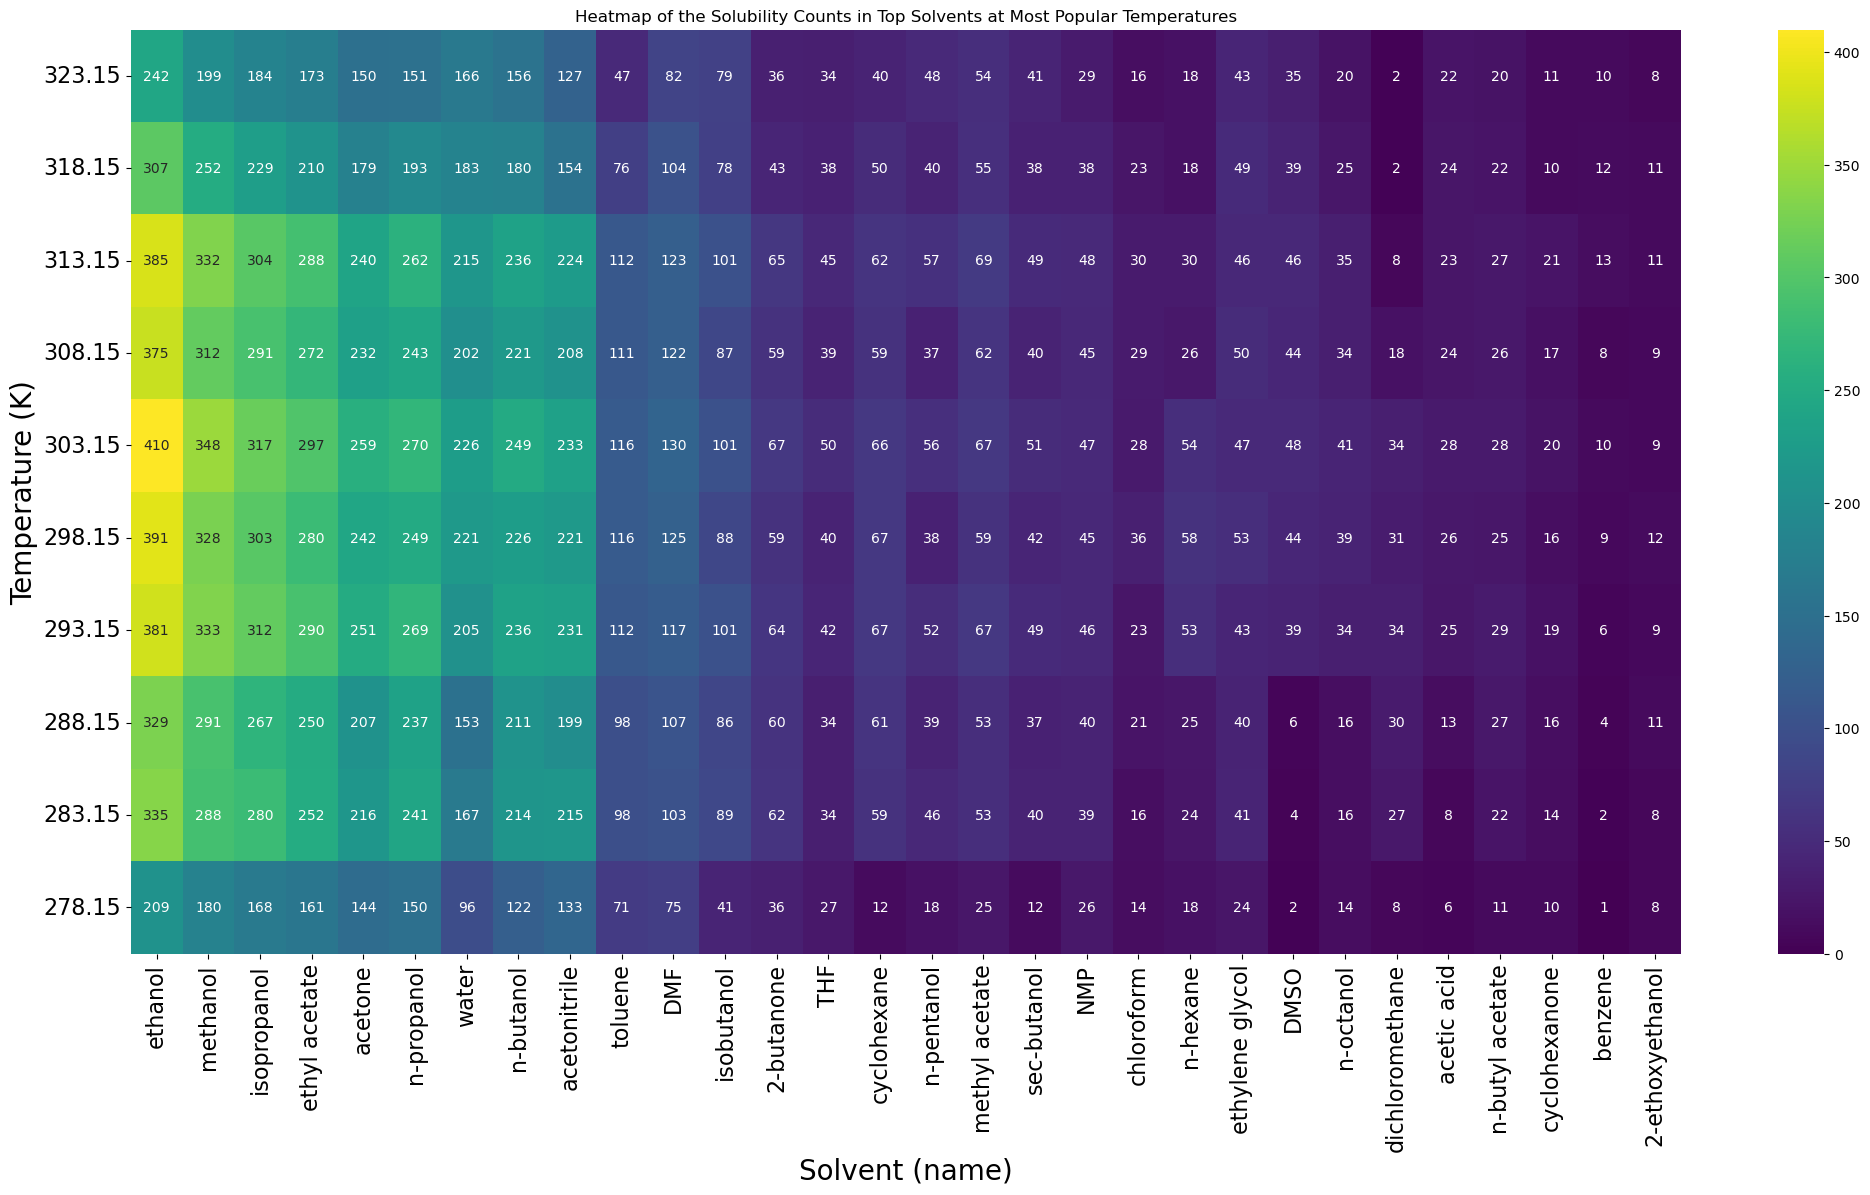

In [29]:
# Specifing the desired order for solvents and temperatures
solvent_order = [
    'ethanol', 'methanol', 'isopropanol', 'ethyl acetate', 'acetone',
    'n-propanol', 'water', 'n-butanol', 'acetonitrile', 'toluene',
    'DMF', 'isobutanol', '2-butanone', 'THF', 'cyclohexane',
    'n-pentanol', 'methyl acetate', 'sec-butanol', 'NMP',
    'chloroform', 'n-hexane', 'ethylene glycol', 'DMSO',
    'n-octanol', 'dichloromethane', 'acetic acid', 'n-butyl acetate',
    'cyclohexanone', 'benzene', '2-ethoxyethanol'
]

temperature_order = [323.15, 318.15, 313.15, 308.15, 303.15, 298.15, 293.15, 288.15, 283.15, 278.15]

# Prepare Heatmap Data
heatmap_data = df_filtered_heatmap.groupby(['Solvent', 'T,K']).size().unstack(fill_value=0)
heatmap_data = heatmap_data.loc[solvent_order, temperature_order]

# Transpose the heatmap_data
heatmap_data = heatmap_data.T

# Create the heatmap
plt.figure(figsize=(25, 12))
sns.heatmap(heatmap_data, vmin=0, cmap='viridis', annot=True, fmt='g')  # Add annotations and format for better readability
plt.yticks(rotation=0)  # No rotation for y-axis labels
plt.tick_params(labelsize=16)
plt.ylabel('Temperature (K)', fontsize=20)
plt.xlabel('Solvent (name)', fontsize=20)
plt.title('Heatmap of the Solubility Counts in Top Solvents at Most Popular Temperatures')
plt.show()

## Exploring Factors Influencing Solubility : Insights from Correlation Matrix:

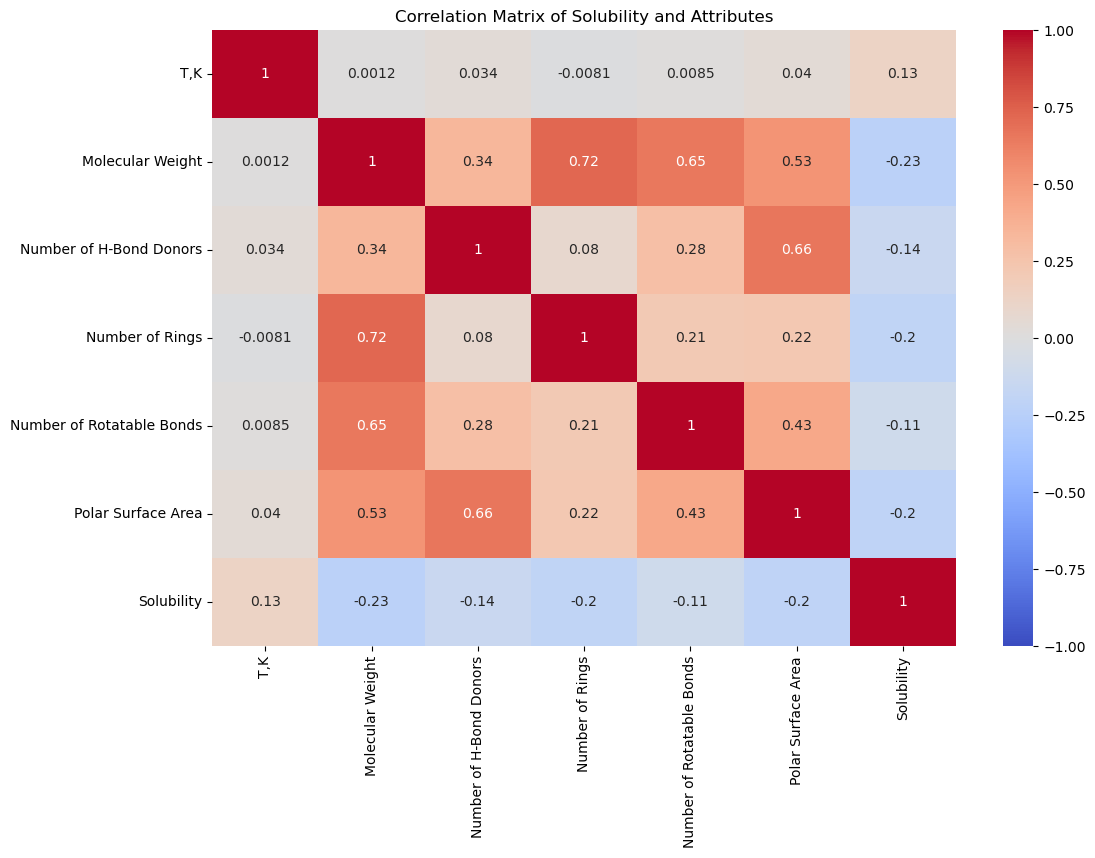

In [30]:
selected_columns = ["T,K", "Molecular Weight", "Number of H-Bond Donors", "Number of Rings", "Number of Rotatable Bonds", "Polar Surface Area", "Solubility"]

# Extract the relevant columns
correlation_df = df[selected_columns]

# Calculate the correlation matrix
correlation_matrix = correlation_df.corr()

# Visualize the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Matrix of Solubility and Attributes")
plt.show()


## **Exploring Solubility Distribution Of the TOP 30 Compounds**


This section introduces a heatmap designed to uncover patterns in solubility measurements across the 30 most popular solvents, focusing on compounds with the highest record counts. By visually exploring these relationships, we aim to gain insights into how solubility varies under prevalent experimental conditions, providing a concise overview of the dataset's characteristics.

**1.   Identify Compounds with the Largest Number of Records:**




Top Solvents:
Index(['ethanol', 'methanol', 'isopropanol', 'ethyl acetate', 'acetone',
       'n-propanol', 'water', 'n-butanol', 'acetonitrile', 'toluene', 'DMF',
       'isobutanol', '2-butanone', 'THF', 'cyclohexane', 'n-pentanol',
       'methyl acetate', 'sec-butanol', 'chloroform', 'n-hexane', 'NMP',
       'ethylene glycol', 'DMSO', 'n-octanol', 'dichloromethane',
       'acetic acid', 'n-butyl acetate', 'cyclohexanone', 'benzene',
       '2-ethoxyethanol'],
      dtype='object')
Top Solvents and Their Percentages:
ethanol: 10.42%
methanol: 8.37%
isopropanol: 7.54%
ethyl acetate: 7.32%
acetone: 6.70%
n-propanol: 6.45%
water: 5.94%
n-butanol: 5.88%
acetonitrile: 5.31%
toluene: 3.28%
Top Compounds (SMILES):
Index(['CN1CCN(C2=Nc3cc(Cl)ccc3Nc3ccccc32)CC1', 'O=C(O)c1ccccc1',
       'Cc1ccccc1S(N)(=O)=O', 'On1nnc2ccccc21',
       'COC(=O)C(C)(C)N=NC(C)(C)C(=O)OC', 'Cc1cc(C(=O)O)ccc1[N+](=O)[O-]',
       'Cn1c(=O)c2c(ncn2CC2OCCO2)n(C)c1=O', 'CN(C)Cc1c[nH]c2ccccc12',
       'S=c1[nH]c2c

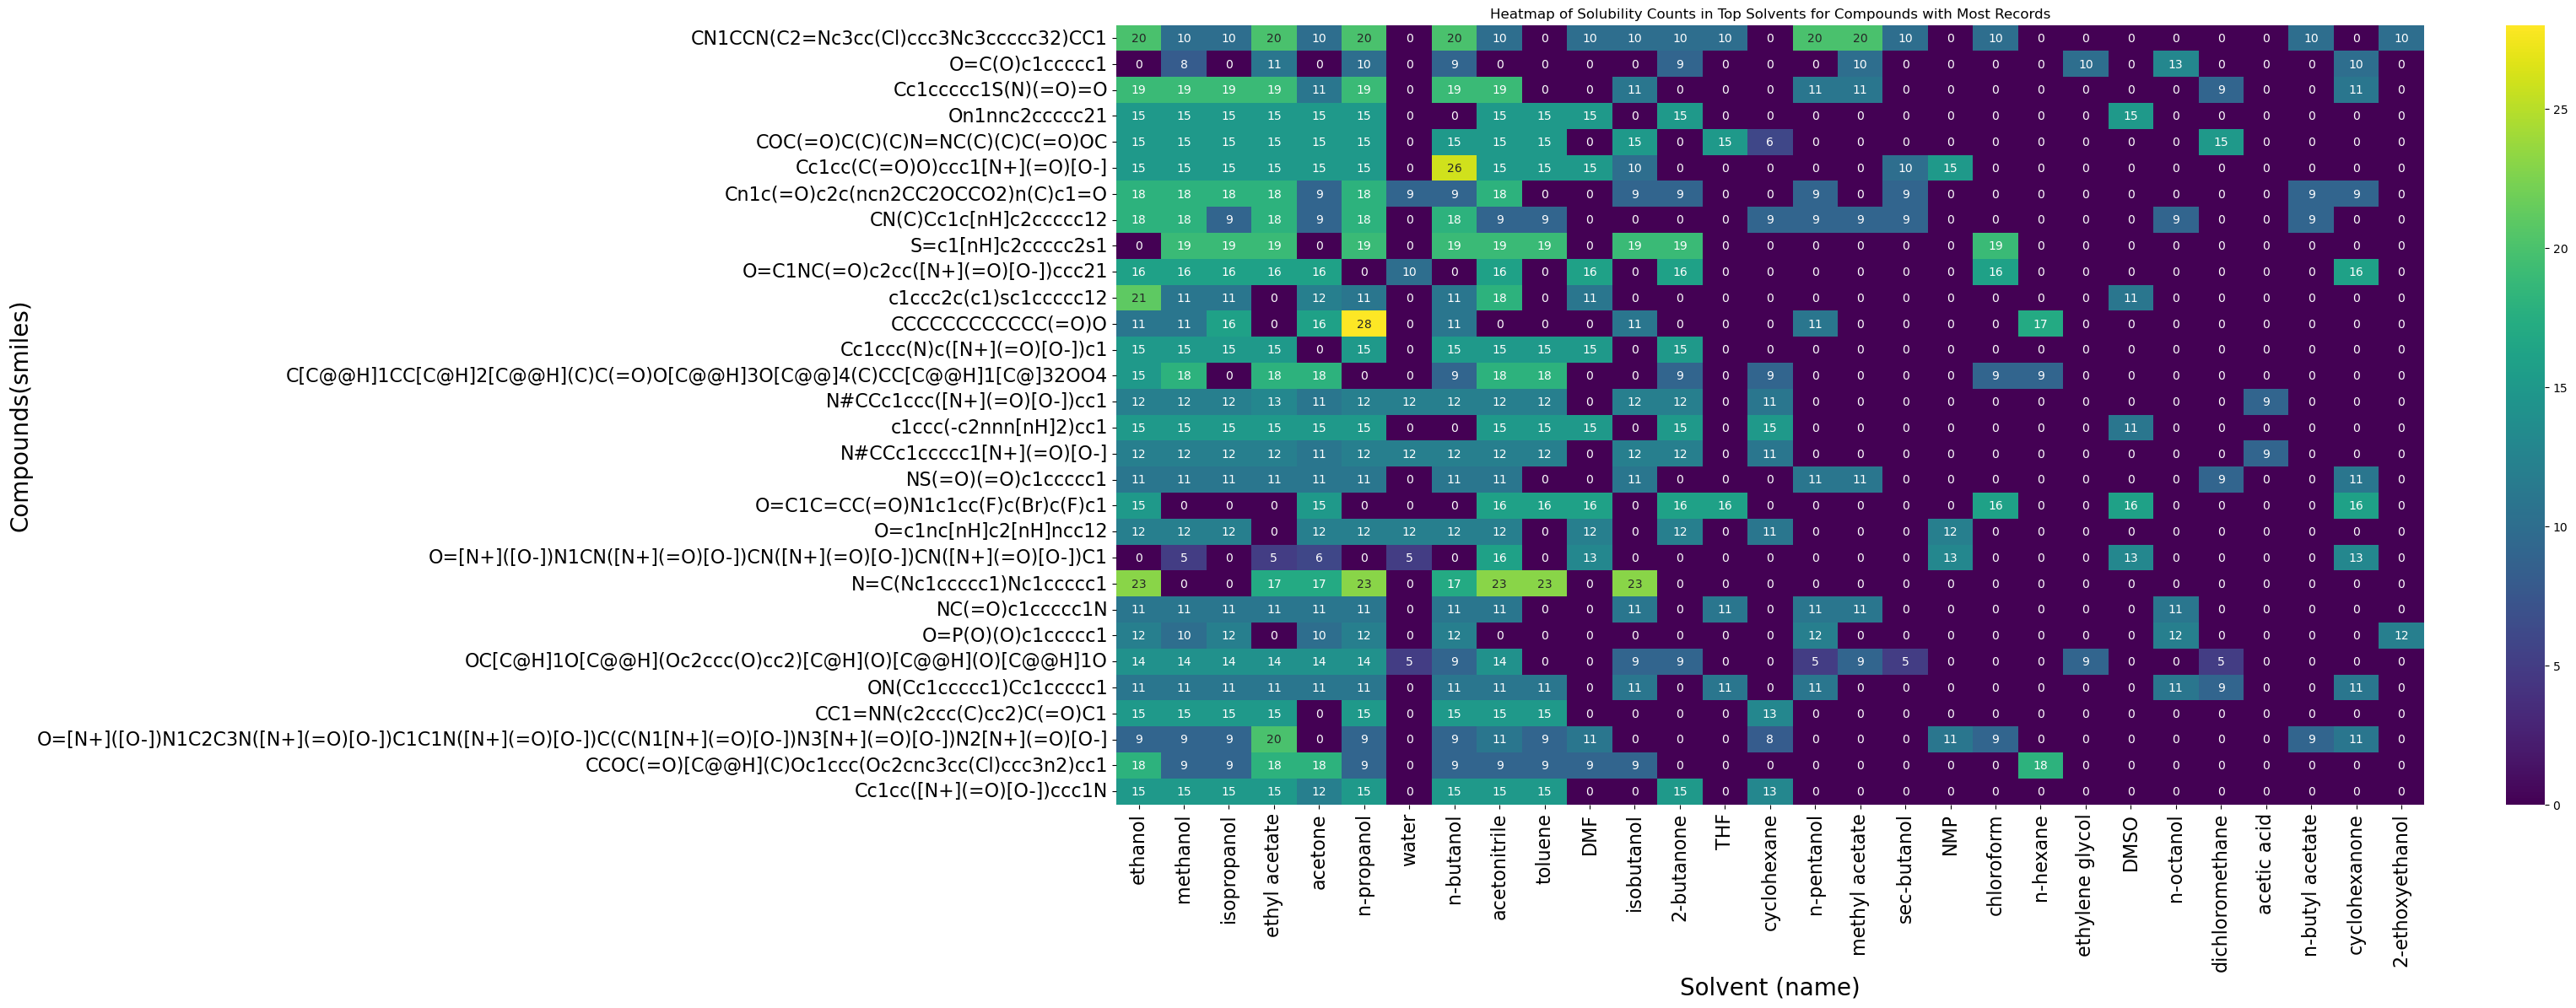

In [31]:
# We will identify the 30 most frequently occurring solvents in the 'Solvent' column.

top30_solvents = df_cleaned['Solvent'].value_counts().head(30).index

# Display the list of top solvents
print("Top Solvents:")
print(top30_solvents)
# Find the Percentage of the Most Popular Solvents
percentage_top30_solvents = df['Solvent'].value_counts(normalize=True).head(30) * 100

# Display the List of Top Solvents and Their Percentages
print("Top Solvents and Their Percentages:")
for solvent, percentage in zip(top_solvents, percentage_top30_solvents):
    print(f"{solvent}: {percentage:.2f}%")

#Identify compounds with the largest number of records
compound_counts = df_cleaned['SMILES'].value_counts()
sorted_top_compounds = compound_counts.head(30).index
# Display the list of top compounds (SMILES)
print("Top Compounds (SMILES):")
print(sorted_top_compounds)

# Filter Dataset  based on the most popular solvents  sorted_top_compounds
df_filtered_heatmape = df[(df['Solvent'].isin(top30_solvents)) & (df['SMILES'].isin(sorted_top_compounds))]

print("\nFiltered Dataset for Heatmap:")
print(df_filtered_heatmape.info())
# Specify the desired order for solvents and temperatures
solvent_order = [
    'ethanol', 'methanol', 'isopropanol', 'ethyl acetate', 'acetone',
    'n-propanol', 'water', 'n-butanol', 'acetonitrile', 'toluene',
    'DMF', 'isobutanol', '2-butanone', 'THF', 'cyclohexane',
    'n-pentanol', 'methyl acetate', 'sec-butanol', 'NMP',
    'chloroform', 'n-hexane', 'ethylene glycol', 'DMSO',
    'n-octanol', 'dichloromethane', 'acetic acid', 'n-butyl acetate',
    'cyclohexanone', '2-ethoxyethanol'
]

top_compounds_order = ['CN1CCN(C2=Nc3cc(Cl)ccc3Nc3ccccc32)CC1', 'O=C(O)c1ccccc1',
       'Cc1ccccc1S(N)(=O)=O', 'On1nnc2ccccc21',
       'COC(=O)C(C)(C)N=NC(C)(C)C(=O)OC', 'Cc1cc(C(=O)O)ccc1[N+](=O)[O-]',
       'Cn1c(=O)c2c(ncn2CC2OCCO2)n(C)c1=O', 'CN(C)Cc1c[nH]c2ccccc12',
       'S=c1[nH]c2ccccc2s1', 'O=C1NC(=O)c2cc([N+](=O)[O-])ccc21',
       'c1ccc2c(c1)sc1ccccc12', 'CCCCCCCCCCCC(=O)O',
       'Cc1ccc(N)c([N+](=O)[O-])c1',
       'C[C@@H]1CC[C@H]2[C@@H](C)C(=O)O[C@@H]3O[C@@]4(C)CC[C@@H]1[C@]32OO4',
       'N#CCc1ccc([N+](=O)[O-])cc1', 'c1ccc(-c2nnn[nH]2)cc1',
       'N#CCc1ccccc1[N+](=O)[O-]', 'NS(=O)(=O)c1ccccc1',
       'O=C1C=CC(=O)N1c1cc(F)c(Br)c(F)c1', 'O=c1nc[nH]c2[nH]ncc12',
       'O=[N+]([O-])N1CN([N+](=O)[O-])CN([N+](=O)[O-])CN([N+](=O)[O-])C1',
       'N=C(Nc1ccccc1)Nc1ccccc1', 'NC(=O)c1ccccc1N', 'O=P(O)(O)c1ccccc1',
       'OC[C@H]1O[C@@H](Oc2ccc(O)cc2)[C@H](O)[C@@H](O)[C@@H]1O',
       'ON(Cc1ccccc1)Cc1ccccc1', 'CC1=NN(c2ccc(C)cc2)C(=O)C1',
       'O=[N+]([O-])N1C2C3N([N+](=O)[O-])C1C1N([N+](=O)[O-])C(C(N1[N+](=O)[O-])N3[N+](=O)[O-])N2[N+](=O)[O-]',
       'CCOC(=O)[C@@H](C)Oc1ccc(Oc2cnc3cc(Cl)ccc3n2)cc1',
       'Cc1cc([N+](=O)[O-])ccc1N']
# Prepare Heatmap Data based on SMILES
heatmape_data = df_filtered_heatmape.groupby(['Solvent', 'SMILES']).size().unstack(fill_value=0)
heatmape_data = heatmape_data.loc[solvent_order, top_compounds_order]
# Transpose the heatmap_data
heatmap_data = heatmape_data.T
# Create the heatmap
plt.figure(figsize=(25, 12))
sns.heatmap(heatmap_data, vmin=0, cmap='viridis', annot=True, fmt='g')  # Add annotations and format for better readability
plt.yticks(rotation=0)  # No rotation for y-axis labels
plt.tick_params(labelsize=16)
plt.ylabel('Compounds(smiles)', fontsize=20)
plt.xlabel('Solvent (name)', fontsize=20)
plt.title('Heatmap of Solubility Counts in Top Solvents for Compounds with Most Records')
plt.show()


## Exploring the distribution of the different attributes using the Box plots




Overall, this loop iterates through each solvent(ethanol and water), extracts relevant data, and creates a separate boxplot within a subplot to visualize the distribution of solubility across the top 10 temperatures for that specific solvent. This provides a detailed and organized overview of the relationship between solvent, temperature, and solubility in our dataset.

The rationale behind selecting ethanol and water as the focal solvents in the analysis lies in their prevalence within the dataset. Ethanol emerges as the most frequently employed solvent, signifying a higher frequency of experimental investigations involving ethanol as the dissolving medium. In addition, water is chosen due to its ubiquity and popularity as a solvent across a broad spectrum of applications.

The decision to focus on the top 10 most frequently encountered temperature values is deliberate. This choice aims to encapsulate a comprehensive overview of the dataset's temperature conditions, providing a representative sample of the experimental landscape.

By concentrating on ethanol and water, along with the specified temperature values, the analysis endeavors to capture a holistic portrayal of the dataset. This approach facilitates a thorough understanding of solubility patterns,

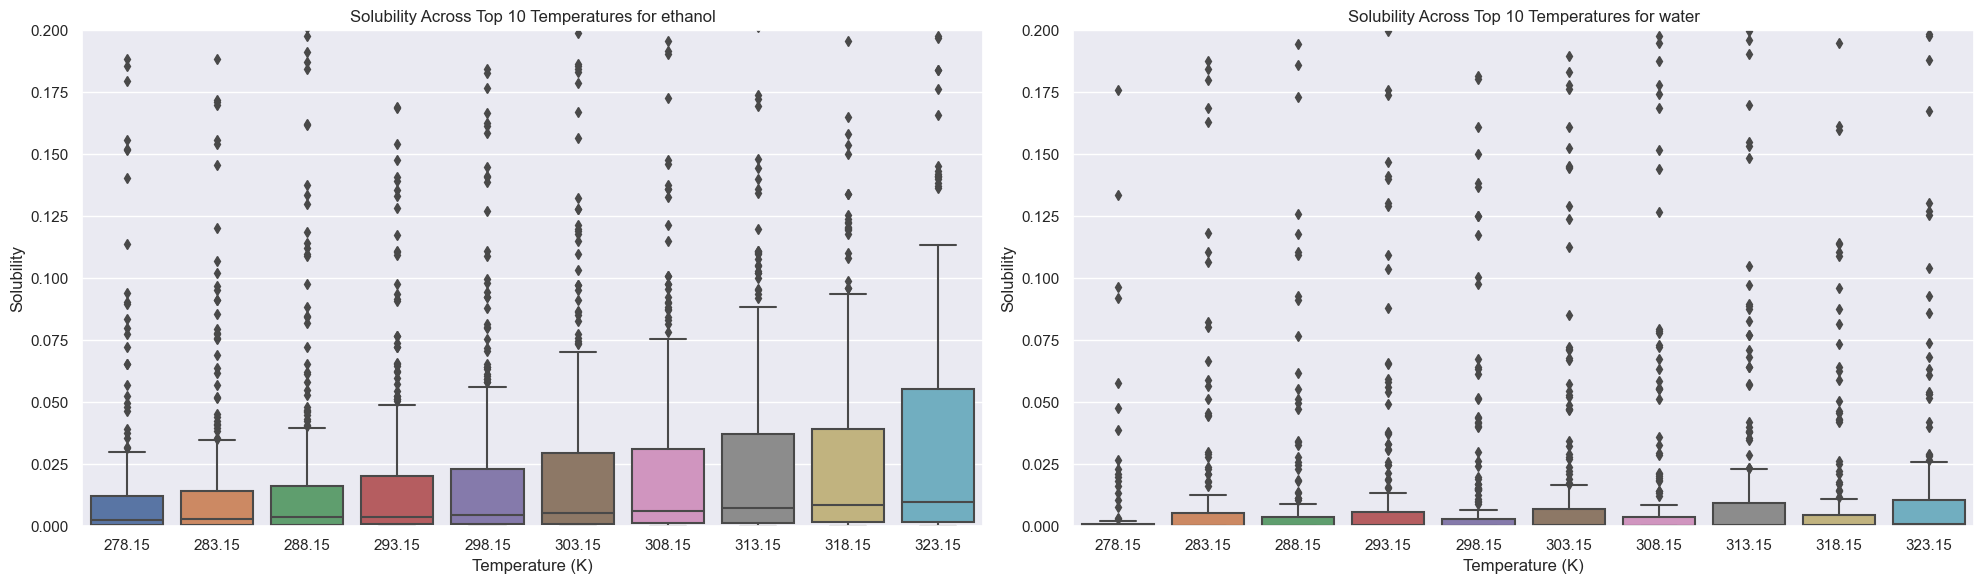

In [32]:
# Choose the top solvent with the highest count
top_solvent = df['Solvent'].value_counts().idxmax()

# Choose 'Water' as the second solvent
solvents = [top_solvent, 'water']

# Create a DataFrame containing only the rows where the solvent is in the top_solvents list
df_top_solvents = df[df['Solvent'].isin(solvents)]

# Create a DataFrame containing only the rows where the temperature is in the top_temperatures list
df_top_temperatures = df_top_solvents[df_top_solvents['T,K'].isin(top10_temperatures)]

# Set the style of seaborn
sns.set(style="darkgrid")

# Create a single subplot for both solvents in the same row
plt.figure(figsize=(20, 6))

# Iterate through each solvent
for i, solvent in enumerate(solvents):
    # Filter data for the current solvent
    df_solvent = df_top_temperatures[df_top_temperatures['Solvent'] == solvent]

    # Create a boxplot for different temperatures
    plt.subplot(1, 2, i+1)
    sns.boxplot(x="T,K", y="Solubility", data=df_solvent)

    # Set title and labels for each subplot
    plt.title(f"Solubility Across Top 10 Temperatures for {solvent}")
    plt.xlabel("Temperature (K)")
    plt.ylabel("Solubility")

    plt.ylim(0.0, 0.2)

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()


In [33]:
def plot_boxplot(df, column_name, dataset_name):
    # Set the style of seaborn
    sns.set(style="darkgrid")

    # Create a box plot for the specified column
    plt.figure(figsize=(20, 2))
    sns.boxplot(x=df[column_name], color='blue', width=0.5, fliersize=5, linewidth=1.5)

    # Set title and labels
    plt.title(f"Distribution of {column_name} in {dataset_name}")
    plt.xlabel(column_name)
    plt.ylabel("")

    # Add a vertical line for the median
    median_value = df[column_name].median()
    plt.axvline(x=median_value, color='red', linestyle='--', linewidth=2, label='Median')

    # Add text annotation for the median value
    plt.text(median_value, 0.5, f'Median: {median_value:.2f}', color='red', ha='center', va='center', backgroundcolor='white')

    # Show the plot
    plt.show()

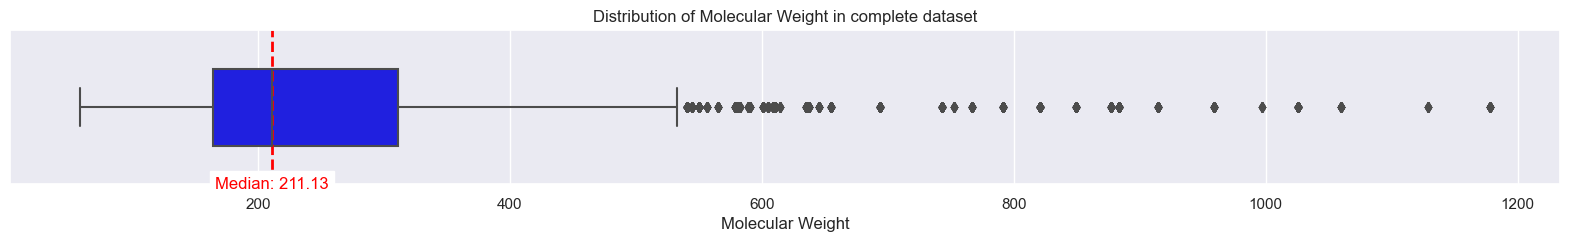

In [34]:
#boxplot of Molecular Weight
plot_boxplot(df, "Molecular Weight","complete dataset")

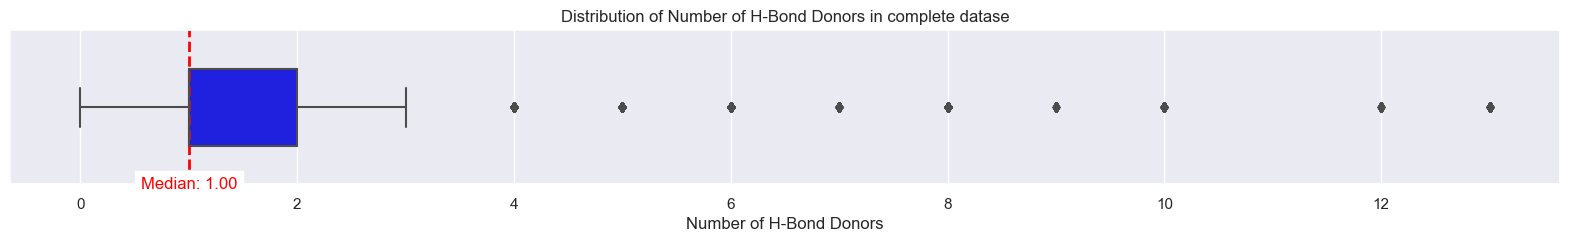

In [35]:
#boxplot of Number of H-Bond Donors
plot_boxplot(df, "Number of H-Bond Donors","complete datase")

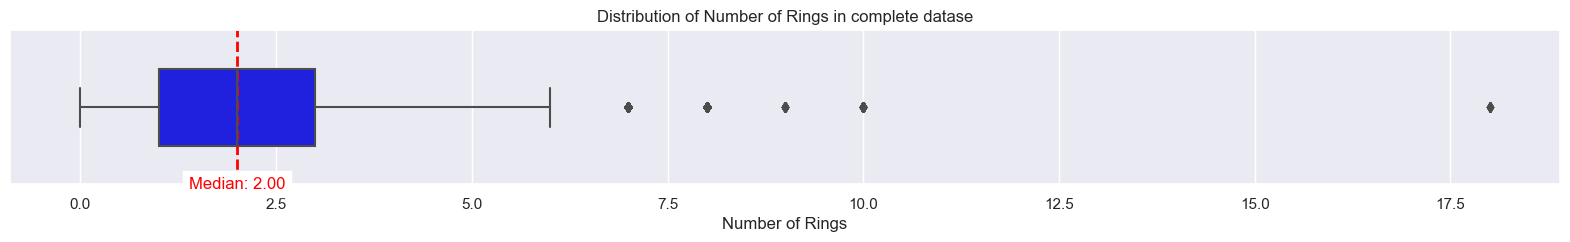

In [36]:
#boxplot of Number of Rings
plot_boxplot(df, "Number of Rings","complete datase")

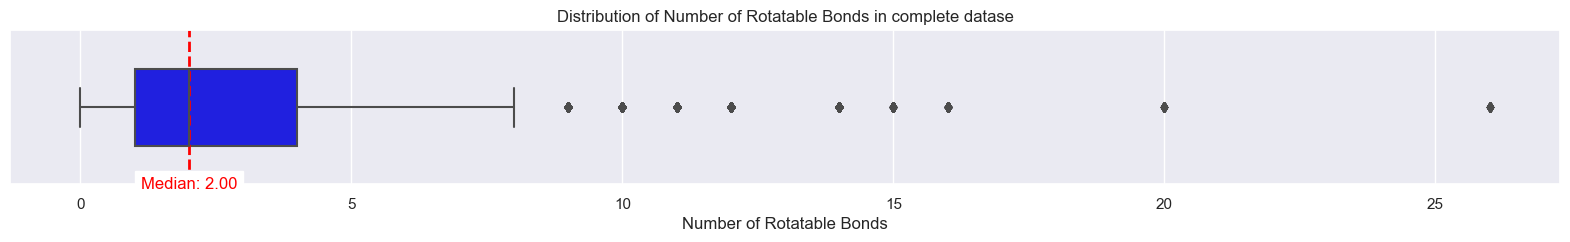

In [37]:
#boxplot of Number of Rotatable Bonds
plot_boxplot(df, "Number of Rotatable Bonds","complete datase")

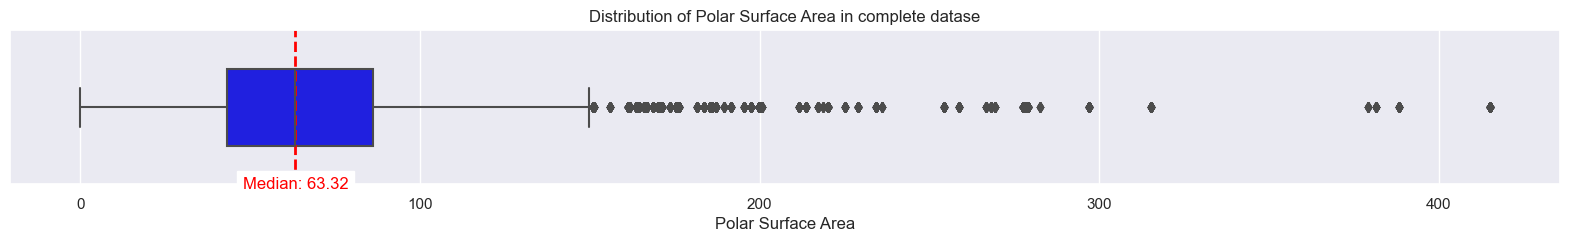

In [38]:
#boxplot of Polar Surface Area
plot_boxplot(df, "Polar Surface Area","complete datase")

In [39]:
# Find the row with the highest solubility in the entire dataset
max_solubility_row = df[df['Solubility'] == df['Solubility'].max()]

# Display the row with the highest solubility in the entire dataset
print("Row with Max Solubility:")
max_solubility_row[['SMILES','Solvent', 'T,K', 'Solubility','Molecular Weight','Number of H-Bond Donors',	'Number of Rings',	'Number of Rotatable Bonds',	'Polar Surface Area']].head()

Row with Max Solubility:


,SMILES,Solvent,"T,K",Solubility,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area
47838,Cc1ccc2ccccc2c1,n-butyl acetate,303.15,0.9506,142.201,0.0,2.0,0.0,0.0


In [40]:
# Find the row with the lowest solubility in the entire dataset
min_solubility_row = df[df['Solubility'] == df['Solubility'].min()]

# Display the row with the lowest solubility in the entire dataset
print("\nRow with Min Solubility:")
min_solubility_row[['SMILES','Solvent', 'T,K', 'Solubility','Molecular Weight','Number of H-Bond Donors',	'Number of Rings',	'Number of Rotatable Bonds',	'Polar Surface Area']].head()


Row with Min Solubility:


,SMILES,Solvent,"T,K",Solubility,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area
18502,Oc1cc(O)c2cc(O)c(-c3cc(O)c(O)c(O)c3)[o+]c2c1,acetone,298.15,5.500000e-11,303.246,6.0,3.0,1.0,132.68


# PART 1: Regression

# Feature Selection

##Unsupervised

### Mutual information

In [41]:
# Select the variables for which we want to calculate Mutual Information
X = df_cleaned[['T,K', 'Molecular Weight', 'Number of H-Bond Donors', 'Number of Rings', 'Number of Rotatable Bonds', 'Polar Surface Area']]
Y = df_cleaned['Solubility']

# Calculate Mutual Information
mi_values = mutual_info_regression(X, Y)

# Print Mutual Information values for each variable
for i, variable in enumerate(X.columns):
    print(f"Mutual Information between '{variable}' and 'Solubility': {mi_values[i]}")

Mutual Information between 'T,K' and 'Solubility': 0.04911463468285859
Mutual Information between 'Molecular Weight' and 'Solubility': 0.4627692586708525
Mutual Information between 'Number of H-Bond Donors' and 'Solubility': 0.06279923309394908
Mutual Information between 'Number of Rings' and 'Solubility': 0.059990315904519864
Mutual Information between 'Number of Rotatable Bonds' and 'Solubility': 0.042500419503473275
Mutual Information between 'Polar Surface Area' and 'Solubility': 0.42003013606327677


### Variance

In [42]:
# Using ExtraTreesRegressor to find the best features
selected_columns = ["T,K", "Molecular Weight", "Number of H-Bond Donors", "Number of Rings", "Number of Rotatable Bonds", "Polar Surface Area"]
X = df_cleaned[selected_columns]
y = df_cleaned["Solubility"]
model = ExtraTreesRegressor()
model.fit(X, y)
# Extracting feature importances
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances = feat_importances.sort_values(ascending=False)
top_features = feat_importances.head(5)
print("\nTop 5 Features based on Importance:")
print(top_features)

# Feature Engineering: Selecting a subset of features based on importance
selected_features = top_features.index
solubility_features = df_cleaned[selected_features]


Top 5 Features based on Importance:
Polar Surface Area           0.257243
Molecular Weight             0.244103
T,K                          0.232588
Number of Rotatable Bonds    0.109444
Number of Rings              0.086699
dtype: float64


In [43]:
#the selected columns of the dataset
selected_columns = ["T,K", "Molecular Weight", "Number of H-Bond Donors", "Number of Rings", "Number of Rotatable Bonds", "Polar Surface Area"]
X = df_cleaned[selected_columns]
#function to select features based on variance
def variance_threshold_selector(X, threshold=0.0):
    selector = VarianceThreshold(threshold)
    selector.fit(X)
    return X[X.columns[selector.get_support(indices=True)]]


X_var = variance_threshold_selector(X, threshold=0.8)
X_var.columns

Index(['T,K', 'Molecular Weight', 'Number of H-Bond Donors', 'Number of Rings',
       'Number of Rotatable Bonds', 'Polar Surface Area'],
      dtype='object')

### Correlation

In [44]:
# Extract features (X) and target variable (y)
X = df_cleaned.drop(['Solubility'], axis=1)
y = df_cleaned['Solubility']

# Calculate correlation values with the target variable and sort in descending order
correlation_values = df_cleaned.corr()['Solubility'].abs().sort_values(ascending=False)

# Select the top k features based on correlation
k = 5
selected_features = correlation_values[1:k+1].index.tolist()

print("Selected Features based on Correlation:")
print(selected_features)




Selected Features based on Correlation:
['Molecular Weight', 'Polar Surface Area', 'Number of Rings', 'Number of H-Bond Donors', 'T,K']


## Supervised

### Correlation

<AxesSubplot:>

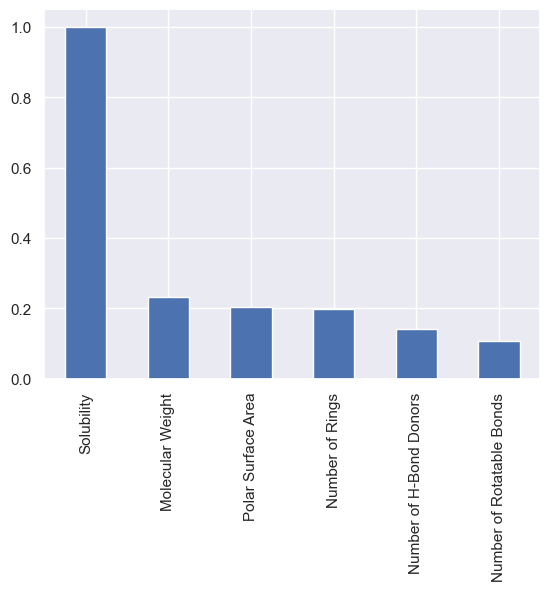

In [45]:
_df=df.drop(['T,K', 'Solvent','SMILES'], axis=1)
# Calculate correlation coefficients
correlation_matrix = _df.corr()
correlation_with_target = correlation_matrix['Solubility'].abs().sort_values(ascending=False)

# Visualize the correlation values
correlation_with_target.plot.bar()

### Information Gain

This code calculates the information gain for selected features in a dataset, focusing on predicting the 'Solubility' target variable. Information gain measures how much each feature reduces uncertainty about solubility. Higher values indicate more informative features. The output shows the information gain for each feature, helping identify key factors influencing solubility prediction.

In [46]:
selected_columns = ["T,K", "Molecular Weight", "Number of H-Bond Donors", "Number of Rings", "Number of Rotatable Bonds", "Polar Surface Area", "Solubility"]
# Extract the relevant columns
information_gain_df = df_cleaned[selected_columns]

# Step 1: Calculate Entropy for the Target Variable (Solubility)
def calculate_entropy(data):
    class_counts = data['Solubility'].value_counts()
    entropy = -sum((count / len(data)) * np.log2(count / len(data)) for count in class_counts)
    return entropy

entropy_target = calculate_entropy(information_gain_df)

# Step 2: Calculate Weighted Entropy for Each Feature
def calculate_weighted_entropy(data, feature):
    weighted_entropy = 0
    for value in data[feature].unique():
        subset = data[data[feature] == value]
        entropy_i = calculate_entropy(subset)
        weighted_entropy += (len(subset) / len(data)) * entropy_i
    return weighted_entropy

# Step 3: Calculate Information Gain
information_gains = {}
for feature in selected_columns[:-1]:  # Exclude the target variable
    weighted_entropy = calculate_weighted_entropy(information_gain_df, feature)
    information_gain = entropy_target - weighted_entropy
    information_gains[feature] = information_gain

# Display Information Gain for each feature
for feature, gain in information_gains.items():
    print(f"Information Gain for '{feature}': {gain}")


Information Gain for 'T,K': 5.109892667807959
Information Gain for 'Molecular Weight': 7.750929152910181
Information Gain for 'Number of H-Bond Donors': 1.3964327189474748
Information Gain for 'Number of Rings': 1.4679919759938862
Information Gain for 'Number of Rotatable Bonds': 1.9946594142535208
Information Gain for 'Polar Surface Area': 6.682845506605598


## Supervised wrapper methods


 In wrapper methods, where model training is necessary for feature selection, handling categorical variables like SMILES and Solvent_SMILES involves encoding. We opt for one-hot encoding over label encoding because it maintains the distinctiveness of each category. One-hot encoding assigns a separate binary column to each category, preventing any unintended ordinal relationships that label encoding might imply. This choice is particularly crucial for maintaining the individuality of categories in the context of chemical data, where SMILES and Solvent_SMILES play a significant role.

###*Label* Encoding

In [47]:
df_cleaned.head()

,SMILES,"T,K",Solubility,Solvent,SMILES_Solvent,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area
0,ON(Cc1ccccc1)Cc1ccccc1,273.15,0.001261,methanol,CO,213.28,1.0,2.0,4.0,23.47
1,ON(Cc1ccccc1)Cc1ccccc1,279.15,0.001713,methanol,CO,213.28,1.0,2.0,4.0,23.47
2,ON(Cc1ccccc1)Cc1ccccc1,283.45,0.002094,methanol,CO,213.28,1.0,2.0,4.0,23.47
3,ON(Cc1ccccc1)Cc1ccccc1,289.05,0.002760,methanol,CO,213.28,1.0,2.0,4.0,23.47
4,ON(Cc1ccccc1)Cc1ccccc1,293.05,0.003327,methanol,CO,213.28,1.0,2.0,4.0,23.47


In [48]:
# Create a label encoder instance
label_encoder = LabelEncoder()

# Apply label encoding to 'SMILES' and 'SMILES_Solvent' columns
df_cleaned['SMILES_encoded'] = label_encoder.fit_transform(df_cleaned['SMILES'])
df_cleaned['SMILES_Solvent_encoded'] = label_encoder.fit_transform(df_cleaned['SMILES_Solvent'])

# Drop the original 'SMILES', 'Solvent', and 'SMILES_Solvent' columns
df_cleaned = df_cleaned.drop(['SMILES', 'Solvent', 'SMILES_Solvent'], axis=1)

# Display the updated DataFrame
df_cleaned.head()


,"T,K",Solubility,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,SMILES_encoded,SMILES_Solvent_encoded
0,273.15,0.001261,213.28,1.0,2.0,4.0,23.47,792,83
1,279.15,0.001713,213.28,1.0,2.0,4.0,23.47,792,83
2,283.45,0.002094,213.28,1.0,2.0,4.0,23.47,792,83
3,289.05,0.002760,213.28,1.0,2.0,4.0,23.47,792,83
4,293.05,0.003327,213.28,1.0,2.0,4.0,23.47,792,83


### wrapper-forwording

In [49]:
# Function for forward selection
def forward_selection(X, y):
    selected_features = []  # Initialize an empty set for selected features

    while True:
        remaining_features = [feature for feature in X.columns if feature not in selected_features]
        pvalues = []

        for feature in remaining_features:
            model = sm.OLS(y, sm.add_constant(X[selected_features + [feature]])).fit()
            pvalues.append((feature, model.pvalues[feature]))

        # Find the feature with the lowest p-value
        best_feature, best_pvalue = min(pvalues, key=lambda x: x[1])

        if best_pvalue < 0.05:
            selected_features.append(best_feature)
        else:
            break

    return selected_features

# Example usage
X = df_cleaned.drop(['Solubility'], axis=1)
y = df_cleaned['Solubility']

# Apply forward selection
selected_features_forward_selection = forward_selection(X, y)

# Display the selected features after forward selection
print("Features selected after forward selection:")
print(selected_features_forward_selection)


Features selected after forward selection:
['Molecular Weight', 'T,K', 'Polar Surface Area', 'Number of Rings', 'Number of Rotatable Bonds', 'SMILES_encoded', 'Number of H-Bond Donors']


### wrapper-backwording

In [50]:

# Perform backward elimination using statsmodels
# Add a constant term to the features
X = sm.add_constant(X)

# Fit the model
model = sm.OLS(y, X).fit()

# Print the summary to see p-values
print(model.summary())
# Check p-values and remove features with p-value above a significance level (e.g., 0.05)
while model.pvalues.max() > 0.05:
    # Remove the feature with the highest p-value
    max_pvalue_feature = model.pvalues.idxmax()
    X = X.drop(columns=[max_pvalue_feature])
    model = sm.OLS(y, X).fit()

# Display the selected features after backward elimination
selected_features_backward_elimination = X.columns[1:]  # Exclude the constant term
print("\nFeatures selected after backward elimination:")
print(selected_features_backward_elimination)


                            OLS Regression Results                            
Dep. Variable:             Solubility   R-squared:                       0.090
Model:                            OLS   Adj. R-squared:                  0.089
Method:                 Least Squares   F-statistic:                     640.3
Date:                Mon, 15 Jan 2024   Prob (F-statistic):               0.00
Time:                        22:28:38   Log-Likelihood:                 46382.
No. Observations:               52047   AIC:                        -9.275e+04
Df Residuals:                   52038   BIC:                        -9.267e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

### wrapper_Genetic algorithm


In [51]:

selected_columns = [
    "T,K", "Molecular Weight", "Number of H-Bond Donors", "Number of Rings",
    "Number of Rotatable Bonds", "Polar Surface Area", "Solubility"
]

# Extract the relevant columns
data = df_cleaned

# Separate features (X) and target variable (y)
X = data.drop("Solubility", axis=1)
y = data["Solubility"]

# Split the Data using Random Sampling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize genetic algorithm parameters
population_size = 10
generations = 5

# Initialize dictionaries to store results for both models before and after feature selection
results_before_linear = {}
results_before_forest = {}
results_after_linear = {}
results_after_forest = {}

# Function to calculate fitness based on R2 score
def calculate_fitness(features):
    model = LinearRegression()  # You can also use RandomForestRegressor()
    model.fit(X_train[features], y_train)
    predictions_test = model.predict(X_test[features])
    r2 = r2_score(y_test, predictions_test)
    return r2


# Function for genetic algorithm
def genetic_algorithm():
    population = [np.random.choice(len(selected_columns) - 1, size=np.random.randint(1, len(selected_columns)), replace=False) for _ in range(population_size)]

    for generation in range(generations):
        fitness_scores = [calculate_fitness([selected_columns[i] for i in features]) for features in population]
        best_indices = np.argsort(fitness_scores)[-population_size // 2:]
        best_population = [population[i] for i in best_indices]

        # Crossover
        crossover_population = []
        for _ in range(population_size // 2):
            parent1, parent2 = np.random.choice(len(best_population), size=2, replace=False)
            parent1, parent2 = best_population[parent1], best_population[parent2]
            crossover_point = np.random.randint(1, min(len(parent1), len(parent2)))
            child = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))
            crossover_population.append(child)

        # Mutation
        mutation_population = [np.random.choice(len(selected_columns) - 1, size=np.random.randint(1, len(selected_columns)), replace=False) for _ in range(population_size // 2)]

        # Create the next generation
        population = best_population + crossover_population + mutation_population

    # Select the best feature subset
    best_features = max(population, key=lambda features: calculate_fitness([selected_columns[i] for i in features]))

    return [selected_columns[i] for i in best_features]

# Train models before feature selection for comparison
models_before = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor()
}

for model_name, model in models_before.items():
    model.fit(X_train, y_train)
    predictions_test = model.predict(X_test)
    r2 = r2_score(y_test, predictions_test)
    mae = mean_absolute_error(y_test, predictions_test)
    mse = mean_squared_error(y_test, predictions_test)

    if model_name == 'Linear Regression':
        results_before_linear[model_name] = {'R2': r2, 'MAE': mae, 'MSE': mse}
    else:  # Random Forest
        results_before_forest[model_name] = {'R2': r2, 'MAE': mae, 'MSE': mse}

# Perform genetic algorithm for feature selection
selected_features_genetic = genetic_algorithm()

# Train models after feature selection
for model_name, model in models_before.items():
    model.fit(X_train[selected_features_genetic], y_train)
    predictions_test = model.predict(X_test[selected_features_genetic])
    r2 = r2_score(y_test, predictions_test)
    mae = mean_absolute_error(y_test, predictions_test)
    mse = mean_squared_error(y_test, predictions_test)

    if model_name == 'Linear Regression':
        results_after_linear[f"Selected Features: {selected_features_genetic}"] = {'R2': r2, 'MAE': mae, 'MSE': mse}
    else:  # Random Forest
        results_after_forest[f"Selected Features: {selected_features_genetic}"] = {'R2': r2, 'MAE': mae, 'MSE': mse}

# Display Results
print("\nResults Before Feature Selection - Linear Regression:")
print(results_before_linear)

print("\nResults Before Feature Selection - Random Forest:")
print(results_before_forest)

print("\nResults After Feature Selection - Linear Regression:")
print(results_after_linear)

print("\nResults After Feature Selection - Random Forest:")
print(results_after_forest)



Results Before Feature Selection - Linear Regression:
{'Linear Regression': {'R2': 0.09083138896633114, 'MAE': 0.06117278896942134, 'MSE': 0.009534124422934127}}

Results Before Feature Selection - Random Forest:
{'Random Forest': {'R2': 0.922232156253727, 'MAE': 0.010504655089198298, 'MSE': 0.0008155234236884681}}

Results After Feature Selection - Linear Regression:
{"Selected Features: ['Polar Surface Area', 'Number of Rings', 'Molecular Weight', 'Number of H-Bond Donors', 'T,K', 'Number of Rotatable Bonds']": {'R2': 0.09032248980950941, 'MAE': 0.06117037716707087, 'MSE': 0.009539461065467734}}

Results After Feature Selection - Random Forest:
{"Selected Features: ['Polar Surface Area', 'Number of Rings', 'Molecular Weight', 'Number of H-Bond Donors', 'T,K', 'Number of Rotatable Bonds']": {'R2': 0.5647681387153494, 'MAE': 0.03368756598694696, 'MSE': 0.004564120085047014}}


# Model Evaluation Functions

In this section, we define functions to evaluate the performance of different regression models. The functions take a dataset and the name of the model as parameters and print key performance metrics. The evaluated metrics include Mean R^2, Mean Squared Error (MSE), Mean Absolute Error (MAE), and Explained Variance Score (EVS).

The following regression models are considered:
- Linear Regression
- Random Forest
- K-Nearest Neighbors (KNN)
- Artificial Neural Network (ANN)
- Support Vector Machine (SVM)
- XGBoost

Let's proceed with the implementation of these evaluation functions.

In [52]:
solvent_counts = df_cleaned['SMILES_Solvent_encoded'].value_counts()

# Get the solvents that appear only once
solvents_to_drop = solvent_counts[solvent_counts == 1].index
df_cleaned = df_cleaned[~df_cleaned['SMILES_Solvent_encoded'].isin(solvents_to_drop)]
solvents_to_drop = solvent_counts[solvent_counts == 4].index

# Drop rows with solvents that appear only once
df_cleaned = df_cleaned[~df_cleaned['SMILES_Solvent_encoded'].isin(solvents_to_drop)]

print(df_cleaned.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52041 entries, 0 to 54272
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   T,K                        52041 non-null  float64
 1   Solubility                 52041 non-null  float64
 2   Molecular Weight           52041 non-null  float64
 3   Number of H-Bond Donors    52041 non-null  float64
 4   Number of Rings            52041 non-null  float64
 5   Number of Rotatable Bonds  52041 non-null  float64
 6   Polar Surface Area         52041 non-null  float64
 7   SMILES_encoded             52041 non-null  int32  
 8   SMILES_Solvent_encoded     52041 non-null  int32  
dtypes: float64(7), int32(2)
memory usage: 3.6 MB
None


In [53]:
X = df_cleaned.drop("Solubility", axis=1)  #dropping solubility
y = df_cleaned["Solubility"]

# Initialize StratifiedShuffleSplit
stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Perform stratified train-test split
for train_index, test_index in stratified_split.split(X, df_cleaned['SMILES_Solvent_encoded']):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

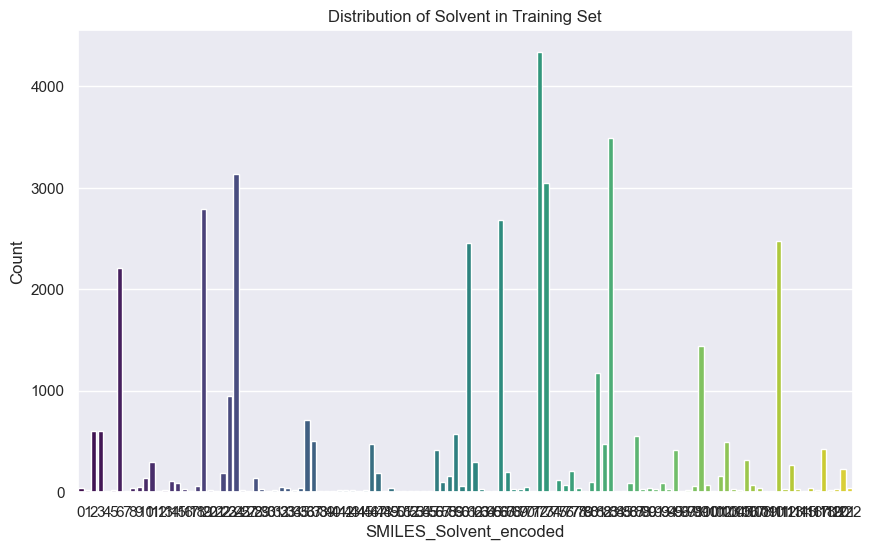

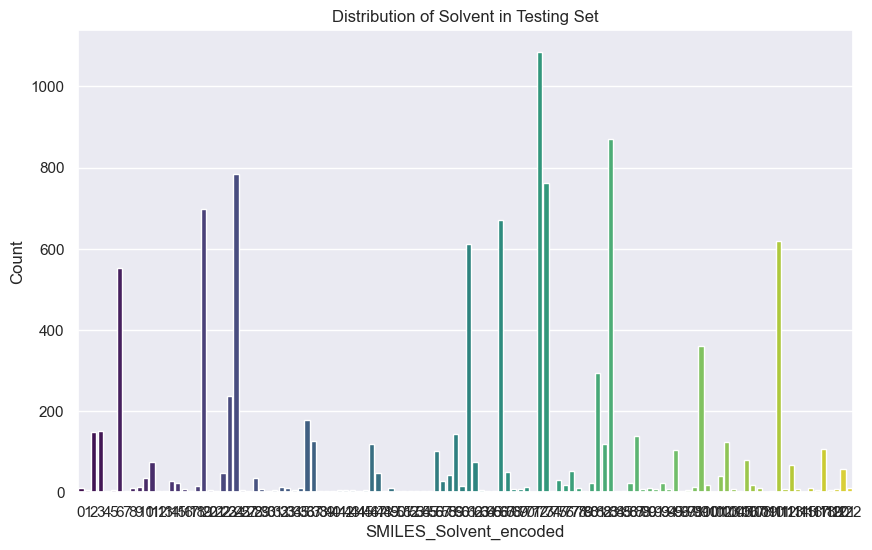

In [54]:
# Plot the distribution of Solvent in the training set
plt.figure(figsize=(10, 6))
sns.countplot(x=X_train['SMILES_Solvent_encoded'], palette='viridis')
plt.title('Distribution of Solvent in Training Set')
plt.xlabel('SMILES_Solvent_encoded')
plt.ylabel('Count')
plt.show()

# Plot the distribution of Solvent in the testing set
plt.figure(figsize=(10, 6))
sns.countplot(x=X_test['SMILES_Solvent_encoded'], palette='viridis')
plt.title('Distribution of Solvent in Testing Set')
plt.xlabel('SMILES_Solvent_encoded')
plt.ylabel('Count')
plt.show()

In [55]:
def evaluate_regression_model_stratified(df, model_name):

    X = df_cleaned.drop(['Solubility'], axis=1)  # Features
    y = df_cleaned['Solubility']  # Target variable
    stratify_attribute = df_cleaned['SMILES_Solvent_encoded']  # Attribute for stratification

    # Instantiate the chosen regression models
    if model_name == "Linear Regression":
        model = LinearRegression()
    elif model_name == "Random Forest":
        model = RandomForestRegressor()
    elif model_name == "KNN":
        model = KNeighborsRegressor()
    elif model_name == "SVM":
        model = SVR()
    elif model_name == "XGBoost":
        model = XGBRegressor()

    else:
        print("Invalid model name.")
        return

    # Initialize StratifiedKFold
    stratified_split = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Perform stratified cross-validation
    cv_scores = cross_val_score(model, X, y, cv=stratified_split.split(X, stratify_attribute), scoring='r2')

    # Print individual R^2 scores for each fold
    print(f"\n{model_name} R^2 Scores for Each Fold:")
    for i, score in enumerate(cv_scores, start=1):
        print(f"Fold {i}: {score}")

    # Calculate mean and variance of R^2 scores
    mean_r2 = np.mean(cv_scores)
    variance_r2 = np.var(cv_scores)

    # Additional metrics for evaluation
    y_pred_cv = cross_val_predict(model, X, y, cv=stratified_split.split(X, stratify_attribute))

    # Calculate other metrics
    mse = mean_squared_error(y, y_pred_cv)
    mae = mean_absolute_error(y, y_pred_cv)
    evs = explained_variance_score(y, y_pred_cv)

    # Display all evaluation metrics
    print(f"\n{model_name} Evaluation Metrics:")
    print(f"Mean R^2: {cv_scores.mean()}")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Explained Variance Score (EVS): {evs}")




### Linear Regression

In [56]:
# Evaluate each model on the original dataset
print("\nEvaluation results for Original Data:\n")
evaluate_regression_model_stratified(df_cleaned, "Linear Regression")



Evaluation results for Original Data:


Linear Regression R^2 Scores for Each Fold:
Fold 1: 0.09380396307490402
Fold 2: 0.08406570952806369
Fold 3: 0.08659904928587048
Fold 4: 0.09010785022238332
Fold 5: 0.09222551151797465

Linear Regression Evaluation Metrics:
Mean R^2: 0.08936041672583923
Mean Squared Error (MSE): 0.009851004097393035
Mean Absolute Error (MAE): 0.062022433941471895
Explained Variance Score (EVS): 0.08939445944120317


### Random Forest


In [57]:
print("\nEvaluation results for Original Data:\n")
evaluate_regression_model_stratified(df_cleaned, "Random Forest")



Evaluation results for Original Data:




Random Forest R^2 Scores for Each Fold:
Fold 1: 0.9105665874242637
Fold 2: 0.920598128814333
Fold 3: 0.9185874894898545
Fold 4: 0.9159348961358776
Fold 5: 0.8930595991905429

Random Forest Evaluation Metrics:
Mean R^2: 0.9117493402109742
Mean Squared Error (MSE): 0.0009568126334960775
Mean Absolute Error (MAE): 0.011031831976578765
Explained Variance Score (EVS): 0.9115560751759392


### K-Nearest Neighbors (KNN)


In [58]:
print("\nEvaluation results for Original Data:\n")
evaluate_regression_model_stratified(df_cleaned, "KNN")


Evaluation results for Original Data:


KNN R^2 Scores for Each Fold:
Fold 1: 0.7879362216747956
Fold 2: 0.7924674563282454
Fold 3: 0.7902145104647256
Fold 4: 0.7881563259988333
Fold 5: 0.7484469153735983

KNN Evaluation Metrics:
Mean R^2: 0.7814442859680397
Mean Squared Error (MSE): 0.002360934080033363
Mean Absolute Error (MAE): 0.02132810977553157
Explained Variance Score (EVS): 0.7817697482601619


### Support Vector Machine (SVM)


In [60]:
print("\nEvaluation results for Original Data:\n")
evaluate_regression_model_stratified(df_cleaned, "SVM")


Evaluation results for Original Data:


SVM R^2 Scores for Each Fold:
Fold 1: -0.10885770608040168
Fold 2: -0.12466268159986749
Fold 3: -0.10657542179087698
Fold 4: -0.10841608706600092
Fold 5: -0.11903115382694973

SVM Evaluation Metrics:
Mean R^2: -0.11350861007281936
Mean Squared Error (MSE): 0.012043684184815275
Mean Absolute Error (MAE): 0.0899258997752294
Explained Variance Score (EVS): 0.08754313245273226


### XGBoost

In [61]:
print("\nEvaluation results for Original Data:\n")
evaluate_regression_model_stratified(df_cleaned, "XGBoost")


Evaluation results for Original Data:


XGBoost R^2 Scores for Each Fold:
Fold 1: 0.8477632919821166
Fold 2: 0.8528876090454277
Fold 3: 0.8516389143279869
Fold 4: 0.8456535818318097
Fold 5: 0.8258188357546075

XGBoost Evaluation Metrics:
Mean R^2: 0.8447524465883897
Mean Squared Error (MSE): 0.0016775124890885795
Mean Absolute Error (MAE): 0.02238428388710738
Explained Variance Score (EVS): 0.8449349471537533


# PART 2: Classification

### ***One Hot Encoding***

In this project, We implemented one-hot encoding for categorical variables based on a tutorial from the TeachOpenCADD project. The tutorial, available [here](https://projects.volkamerlab.org/teachopencadd/talktorials/T021_one_hot_encoding.html), provided valuable insights and code snippets for efficiently handling categorical data in a machine learning context.

I've adapted the approach to our specific dataset, applying one-hot encoding to enhance the representation of categorical columns. The following code snippet demonstrates the implementation:

In [62]:
df = df_original
df.head()

,SMILES,"T,K",Solubility,Solvent,SMILES_Solvent,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,SMILES_encoded,SMILES_Solvent_encoded
0,ON(Cc1ccccc1)Cc1ccccc1,273.15,0.001261,methanol,CO,213.28,1.0,2.0,4.0,23.47,792,83
1,ON(Cc1ccccc1)Cc1ccccc1,279.15,0.001713,methanol,CO,213.28,1.0,2.0,4.0,23.47,792,83
2,ON(Cc1ccccc1)Cc1ccccc1,283.45,0.002094,methanol,CO,213.28,1.0,2.0,4.0,23.47,792,83
3,ON(Cc1ccccc1)Cc1ccccc1,289.05,0.002760,methanol,CO,213.28,1.0,2.0,4.0,23.47,792,83
4,ON(Cc1ccccc1)Cc1ccccc1,293.05,0.003327,methanol,CO,213.28,1.0,2.0,4.0,23.47,792,83


In [63]:
def assess_two_letter_elements(df, column_name):
    """
    Find the two letter elements in a specific column of the dataframe.

    Parameters
    ----------
    df : pandas.DataFrame
        Dataframe which requires preprocessing.
    column_name : str
        Name of the column to analyze.

    Returns
    -------
    two_letter_elements : list
        List with found two letter elements.
    """

    # Filter out NaN values in the specified column
    df_filtered = df[df[column_name].notna()]

    # Search for unique characters in the specified column
    unique_chars = set(df_filtered[column_name].apply(lambda x: [c for c in str(x)]).sum())

    # Get upper and lower case letters only
    upper_chars = []
    lower_chars = []

    for entry in unique_chars:
        if entry.isalpha():
            if entry.isupper():
                upper_chars.append(entry)
            elif entry.islower():
                lower_chars.append(entry)

    print(f"Upper letter characters {sorted(upper_chars)}")
    print(f"Lower letter characters {sorted(lower_chars)}")


    # List of all possible periodic elements
    periodic_elements = [
        "Ac", "Al", "Am", "Sb", "Ar", "As", "At", "Ba", "Bk", "Be", "Bi", "Bh", "B",
        "Br", "Cd", "Ca", "Cf", "C", "Ce", "Cs", "Cl", "Cr", "Co", "Cn", "Cu", "Cm",
        "Ds", "Db", "Dy", "Es", "Er", "Eu", "Fm", "Fl", "F", "Fr", "Gd", "Ga", "Ge",
        "Au", "Hf", "Hs", "He", "Ho", "H", "In", "I", "Ir", "Fe", "Kr", "La", "Lr",
        "Pb", "Li", "Lv", "Lu", "Mg", "Mn", "Mt", "Md", "Hg", "Mo", "Mc", "Nd", "Ne",
        "Np", "Ni", "Nh", "Nb", "N", "No", "Og", "Os", "O", "Pd", "P", "Pt", "Pu",
        "Po", "K", "Pr", "Pm", "Pa", "Ra", "Rn", "Re", "Rh", "Rg", "Rb", "Ru", "Rf",
        "Sm", "Sc", "Sg", "Se", "Si", "Ag", "Na", "Sr", "S", "Ta", "Tc", "Te", "Ts",
        "Tb", "Tl", "Th", "Tm", "Sn", "Ti", "W", "U", "V", "Xe", "Yb", "Y", "Zn", "Zr"
    ]

    # The two_char_elements list contains all two letter elements
    # which can be generated by all possible combination of upper x lower characters
    # and are valid periodic elements.
    two_char_elements = []
    for upper in upper_chars:
        for lower in lower_chars:
            ch = upper + lower
            if ch in periodic_elements:
                two_char_elements.append(ch)

    # This list is then reduced to the subset of two-letter elements
    # that actually appear in the specified column, specific to our data set.
    two_char_elements_column = set()
    for char in two_char_elements:
        if df[column_name].str.contains(char).any():
            two_char_elements_column.add(char)

    return two_char_elements_column


In [64]:
elements_found = assess_two_letter_elements(df,"SMILES")
print(f"\nTwo letter elements found in the data set: {sorted(elements_found)}")

elements_found = assess_two_letter_elements(df,"SMILES_Solvent")
print(f"\nTwo letter elements found in the data set: {sorted(elements_found)}")

Upper letter characters ['B', 'C', 'F', 'H', 'I', 'K', 'L', 'N', 'O', 'P', 'S']
Lower letter characters ['a', 'c', 'e', 'i', 'l', 'n', 'o', 'r', 's']

Two letter elements found in the data set: ['Br', 'Ca', 'Cl', 'Cn', 'Li', 'Na', 'Sc', 'Se']
Upper letter characters ['B', 'C', 'N', 'O', 'P', 'S']
Lower letter characters ['c', 'l', 'n', 'r']

Two letter elements found in the data set: ['Br', 'Cl']


In [65]:
replacement_dict1 = {
    'Br': 'R',
    'Cl': 'D',
    'Se': 'E',
    'Ca': 'A',
    'Cn': 'X',
    'Li': 'Y',
    'Na': 'W',
    'Sc': 'V',
}

replacement_dict2 = {
    'Br': 'R',
    'Cl': 'D',
}

In [66]:
def preprocessing_data(df, replacement, column_name):
    """
    Preprocess the SMILES structures in a data set.

    Parameters
    ----------
    df : pandas.DataFrame
        Dataframe which requires preprocessing.
    replacement : dict
        Dictionary with mapping for replacement.
    column_name : str
        Name of the column to preprocess.

    Returns
    -------
    df : pandas.DataFrame
        Dataframe with a new processed canonical column.
    unique_char : list
        List with unique characters present in the specified column.
    """

    # Create a new column having processed canonical data
    df["processed_" + column_name] = df[column_name].copy()

    # Replace the two letter elements found with one character
    for pattern, repl in replacement.items():
        df["processed_" + column_name] = df["processed_" + column_name].str.replace(
            pattern, repl
        )

    # Check and handle NaN values
    df["processed_" + column_name].fillna("", inplace=True)

    unique_char = set(df["processed_" + column_name].apply(list).sum())
    return df, unique_char


In [67]:
# Preprocess "SMILES" column
df, unique_char_smiles = preprocessing_data(df, replacement_dict1, "SMILES")
# Preprocess "SMILES_Solvent" column
df, unique_char_solvent = preprocessing_data(df, replacement_dict2, "SMILES_Solvent")

df.head(5)

,SMILES,"T,K",Solubility,Solvent,SMILES_Solvent,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,SMILES_encoded,SMILES_Solvent_encoded,processed_SMILES,processed_SMILES_Solvent
0,ON(Cc1ccccc1)Cc1ccccc1,273.15,0.001261,methanol,CO,213.28,1.0,2.0,4.0,23.47,792,83,ON(Cc1ccccc1)Cc1ccccc1,CO
1,ON(Cc1ccccc1)Cc1ccccc1,279.15,0.001713,methanol,CO,213.28,1.0,2.0,4.0,23.47,792,83,ON(Cc1ccccc1)Cc1ccccc1,CO
2,ON(Cc1ccccc1)Cc1ccccc1,283.45,0.002094,methanol,CO,213.28,1.0,2.0,4.0,23.47,792,83,ON(Cc1ccccc1)Cc1ccccc1,CO
3,ON(Cc1ccccc1)Cc1ccccc1,289.05,0.002760,methanol,CO,213.28,1.0,2.0,4.0,23.47,792,83,ON(Cc1ccccc1)Cc1ccccc1,CO
4,ON(Cc1ccccc1)Cc1ccccc1,293.05,0.003327,methanol,CO,213.28,1.0,2.0,4.0,23.47,792,83,ON(Cc1ccccc1)Cc1ccccc1,CO


In [68]:
print(f"All unique characters found in the preprocessed data set:\n{sorted(unique_char_smiles)}")
print(f"All unique characters found in the preprocessed data set:\n{sorted(unique_char_solvent)}")

All unique characters found in the preprocessed data set:
['#', '%', '(', ')', '+', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '=', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'H', 'I', 'K', 'N', 'O', 'P', 'R', 'S', 'V', 'W', 'X', 'Y', '[', '\\', ']', 'c', 'n', 'o', 's']
All unique characters found in the preprocessed data set:
['#', '(', ')', '.', '1', '2', '=', 'C', 'D', 'N', 'O', 'P', 'R', 'S', 'c', 'n']


In [69]:
df.head()

,SMILES,"T,K",Solubility,Solvent,SMILES_Solvent,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,SMILES_encoded,SMILES_Solvent_encoded,processed_SMILES,processed_SMILES_Solvent
0,ON(Cc1ccccc1)Cc1ccccc1,273.15,0.001261,methanol,CO,213.28,1.0,2.0,4.0,23.47,792,83,ON(Cc1ccccc1)Cc1ccccc1,CO
1,ON(Cc1ccccc1)Cc1ccccc1,279.15,0.001713,methanol,CO,213.28,1.0,2.0,4.0,23.47,792,83,ON(Cc1ccccc1)Cc1ccccc1,CO
2,ON(Cc1ccccc1)Cc1ccccc1,283.45,0.002094,methanol,CO,213.28,1.0,2.0,4.0,23.47,792,83,ON(Cc1ccccc1)Cc1ccccc1,CO
3,ON(Cc1ccccc1)Cc1ccccc1,289.05,0.002760,methanol,CO,213.28,1.0,2.0,4.0,23.47,792,83,ON(Cc1ccccc1)Cc1ccccc1,CO
4,ON(Cc1ccccc1)Cc1ccccc1,293.05,0.003327,methanol,CO,213.28,1.0,2.0,4.0,23.47,792,83,ON(Cc1ccccc1)Cc1ccccc1,CO


In [70]:
# Index of the longest SMILES string in "SMILES" column
longest_smiles = max(df["SMILES"], key=len)
longest_smiles_index = df.SMILES[df.SMILES == longest_smiles].index.tolist()
print(f"Longest SMILES (SMILES column): {longest_smiles}")
print(f"Contains {len(longest_smiles)} characters, index in dataframe: {longest_smiles_index[0]}.")

# Index of the shortest SMILES string in "SMILES" column
shortest_smiles = min(df["SMILES"], key=len)
shortest_smiles_index = df.SMILES[df.SMILES == shortest_smiles].index.tolist()
print(f"Shortest SMILES (SMILES column): {shortest_smiles}")
print(f"Contains {len(shortest_smiles)} characters, index in dataframe: {shortest_smiles_index[0]}.")

# Index of the longest SMILES string in "SMILES_Solvent" column
longest_smiles_solvent = max(df["SMILES_Solvent"], key=len)
longest_smiles_solvent_index = df.SMILES_Solvent[df.SMILES_Solvent == longest_smiles_solvent].index.tolist()
print(f"Longest SMILES (SMILES_Solvent column): {longest_smiles_solvent}")
print(f"Contains {len(longest_smiles_solvent)} characters, index in dataframe: {longest_smiles_solvent_index[0]}.")

# Index of the shortest SMILES string in "SMILES_Solvent" column
shortest_smiles_solvent = min(df["SMILES_Solvent"], key=len)
shortest_smiles_solvent_index = df.SMILES_Solvent[df.SMILES_Solvent == shortest_smiles_solvent].index.tolist()
print(f"Shortest SMILES (SMILES_Solvent column): {shortest_smiles_solvent}")
print(f"Contains {len(shortest_smiles_solvent)} characters, index in dataframe: {shortest_smiles_solvent_index[0]}.")


Longest SMILES (SMILES column): C[C@@H]1[C@H]2C3=CC[C@@H]4[C@@]5(C)C[C@@H](O)[C@H](O)[C@@](C)(CO)[C@@H]5CC[C@@]4(C)[C@]3(C)CC[C@@]2(C(=O)O[C@@H]2O[C@H](CO[C@@H]3O[C@H](CO)[C@@H](O[C@@H]4O[C@@H](C)[C@H](O)[C@@H](O)[C@H]4O)[C@H](O)[C@H]3O)[C@@H](O)[C@H](O)[C@H]2O)CC[C@H]1C
Contains 239 characters, index in dataframe: 2381.
Shortest SMILES (SMILES column): NC(N)=S
Contains 7 characters, index in dataframe: 2596.
Longest SMILES (SMILES_Solvent column): CCCCCCCCCCCCCC=CC(C(COC(=O)CCC(=O)OCCOC)NC(=O)CCCCCCC)O
Contains 55 characters, index in dataframe: 53837.
Shortest SMILES (SMILES_Solvent column): O
Contains 1 characters, index in dataframe: 39018.


In [71]:
def smiles_encoder(smiles, max_len, unique_char):
    """
    Function defined using all unique characters in our
    processed canonical SMILES structures created
    with the preprocessing_data function.

    Parameters
    ----------
    smiles : str
         SMILES of a molecule in string format.
    unique_char : list
         List of unique characters in the string data set.
    max_len : int
         Maximum length of the SMILES string.

    Returns
    -------
    smiles_matrix : numpy.ndarray
         One-hot encoded matrix of fixed shape
         (unique char in smiles, max SMILES length).
    """
    # create dictionary of the unique char data set
    smi2index = {char: index for index, char in enumerate(unique_char)}
    # one-hot encoding
    # zero padding to max_len
    smiles_matrix = np.zeros((len(unique_char), max_len))
    for index, char in enumerate(smiles):
        smiles_matrix[smi2index[char], index] = 1
    return smiles_matrix



In [72]:
# Apply the function to the processed canonical SMILES strings in "SMILES" column
df["unique_char_ohe_matrix_smiles"] = df["processed_SMILES"].apply(
    smiles_encoder, max_len=len(longest_smiles), unique_char=unique_char_smiles
)


# Apply the function to the processed canonical SMILES strings in "SMILES_Solvent" column
df["unique_char_ohe_matrix_solvent"] = df["processed_SMILES_Solvent"].apply(
    smiles_encoder, max_len=len(longest_smiles_solvent), unique_char=unique_char_solvent
)

In [73]:
df.head()

,SMILES,"T,K",Solubility,Solvent,SMILES_Solvent,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,SMILES_encoded,SMILES_Solvent_encoded,processed_SMILES,processed_SMILES_Solvent,unique_char_ohe_matrix_smiles,unique_char_ohe_matrix_solvent
0,ON(Cc1ccccc1)Cc1ccccc1,273.15,0.001261,methanol,CO,213.28,1.0,2.0,4.0,23.47,792,83,ON(Cc1ccccc1)Cc1ccccc1,CO,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,ON(Cc1ccccc1)Cc1ccccc1,279.15,0.001713,methanol,CO,213.28,1.0,2.0,4.0,23.47,792,83,ON(Cc1ccccc1)Cc1ccccc1,CO,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,ON(Cc1ccccc1)Cc1ccccc1,283.45,0.002094,methanol,CO,213.28,1.0,2.0,4.0,23.47,792,83,ON(Cc1ccccc1)Cc1ccccc1,CO,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,ON(Cc1ccccc1)Cc1ccccc1,289.05,0.002760,methanol,CO,213.28,1.0,2.0,4.0,23.47,792,83,ON(Cc1ccccc1)Cc1ccccc1,CO,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,ON(Cc1ccccc1)Cc1ccccc1,293.05,0.003327,methanol,CO,213.28,1.0,2.0,4.0,23.47,792,83,ON(Cc1ccccc1)Cc1ccccc1,CO,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [74]:
# Specify the index of the SMILES string we're interested in
index_to_check = 100

# Get the SMILES string at the specified index
smiles_string = df.at[index_to_check, "SMILES"]

# Get the number of characters in the SMILES string
num_characters = len(smiles_string)

# Print the result
print(f"The number of characters in the SMILES at index {index_to_check} is: {num_characters}")


The number of characters in the SMILES at index 100 is: 46


In [75]:
# Specify the index of the SMILES string we want to visualize
index_to_visualize=100

# Retrieve the one-hot encoded matrix for the specified index
one_hot_matrix = df.at[index_to_visualize, "unique_char_ohe_matrix_smiles"]

# Print the one-hot encoding matrix for a specific SMILES string
print(f"One-Hot Encoding for SMILES at Index {index_to_visualize}:")

# Print each row of the one-hot encoding matrix
for row in one_hot_matrix:
    print(row)



One-Hot Encoding for SMILES at Index 100:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0

In [ ]:

# Specify the index of the SMILES string we want to visualize
index_to_visualize=1000

# Retrieve the one-hot encoded matrix for the specified index
one_hot_matrix = df.at[index_to_visualize, "unique_char_ohe_matrix_solvent"]

# Print the one-hot encoding matrix for a specific SMILES string
print(f"One-Hot Encoding for SMILES at Index {index_to_visualize}:")

# Print each row of the one-hot encoding matrix
for row in one_hot_matrix:
    print(row)

One-Hot Encoding for SMILES at Index 1000:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0.]
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [76]:
df = df.drop(['SMILES'],axis=1)
df = df.drop(['SMILES_Solvent'],axis=1)
df = df.drop(['processed_SMILES'],axis=1)
df = df.drop(['processed_SMILES_Solvent'],axis=1)
# Display basic information about the dataset
print("Original Dataset Info:")
print(df.info())
df.head()

Original Dataset Info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 52047 entries, 0 to 54272
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   T,K                             52047 non-null  float64
 1   Solubility                      52047 non-null  float64
 2   Solvent                         52047 non-null  object 
 3   Molecular Weight                52047 non-null  float64
 4   Number of H-Bond Donors         52047 non-null  float64
 5   Number of Rings                 52047 non-null  float64
 6   Number of Rotatable Bonds       52047 non-null  float64
 7   Polar Surface Area              52047 non-null  float64
 8   SMILES_encoded                  52047 non-null  int32  
 9   SMILES_Solvent_encoded          52047 non-null  int32  
 10  unique_char_ohe_matrix_smiles   52047 non-null  object 
 11  unique_char_ohe_matrix_solvent  52047 non-null  object 
dtypes: float6

,"T,K",Solubility,Solvent,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,SMILES_encoded,SMILES_Solvent_encoded,unique_char_ohe_matrix_smiles,unique_char_ohe_matrix_solvent
0,273.15,0.001261,methanol,213.28,1.0,2.0,4.0,23.47,792,83,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,279.15,0.001713,methanol,213.28,1.0,2.0,4.0,23.47,792,83,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,283.45,0.002094,methanol,213.28,1.0,2.0,4.0,23.47,792,83,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,289.05,0.002760,methanol,213.28,1.0,2.0,4.0,23.47,792,83,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,293.05,0.003327,methanol,213.28,1.0,2.0,4.0,23.47,792,83,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [ ]:
# Specify the path for the new CSV file
new_file_path = '/Dataset/HotEncoded_SolubiltyDB.csv'

# Save the DataFrame to a new CSV file
df.to_csv(new_file_path, index=False)

print(f'Data has been saved to {new_file_path}')

##Classification

In [77]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import OneHotEncoder
import xgboost
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
import numpy as np
from xgboost import XGBClassifier

In [78]:
file_path = 'Dataset/HotEncoded_SolubilityDB.csv'
# Specify column names manually
columns = ["T,K",	"Solubility", "Molecular Weight",	"Number of H-Bond Donors",	"Number of Rings",	"Number of Rotatable Bonds" ,	"Polar Surface Area",	"unique_char_ohe_matrix_smiles","unique_char_ohe_matrix_solvent"]
# Read the CSV file into a DataFrame with the specified column names
df = pd.read_csv(file_path, names=columns ,skiprows=1)

# Display basic information about the dataset
print("Original Dataset Info:")
print(df.info())


Original Dataset Info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 52047 entries, 0 to 54272
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   T,K                             52047 non-null  float64
 1   Solubility                      52047 non-null  float64
 2   Molecular Weight                52047 non-null  float64
 3   Number of H-Bond Donors         52047 non-null  float64
 4   Number of Rings                 52047 non-null  float64
 5   Number of Rotatable Bonds       52047 non-null  float64
 6   Polar Surface Area              52047 non-null  float64
 7   unique_char_ohe_matrix_smiles   52047 non-null  object 
 8   unique_char_ohe_matrix_solvent  52047 non-null  object 
dtypes: float64(7), object(2)
memory usage: 4.0+ MB
None


In [79]:
#deleting nan and duplicates
df= df.dropna()
df_filtered =df.drop_duplicates()
df.head(4)

,"T,K",Solubility,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,unique_char_ohe_matrix_smiles,unique_char_ohe_matrix_solvent
0,273.15,0.001261,213.28,1.0,2.0,4.0,23.47,[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0. 0....,[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0....
1,279.15,0.001713,213.28,1.0,2.0,4.0,23.47,[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0. 0....,[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0....
2,283.45,0.002094,213.28,1.0,2.0,4.0,23.47,[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0. 0....,[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0....
3,289.05,0.002760,213.28,1.0,2.0,4.0,23.47,[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0. 0....,[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0....


In [80]:
solvent_counts = df['unique_char_ohe_matrix_solvent'].value_counts()

# Get the solvents that appear only once
solvents_to_drop = solvent_counts[solvent_counts == 1].index

# Drop rows with solvents that appear only once
df_filtered = df[~df['unique_char_ohe_matrix_solvent'].isin(solvents_to_drop)]

# Display information about the filtered DataFrame
print("Filtered Dataset Info:")
print(df_filtered.info())


Filtered Dataset Info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 52046 entries, 0 to 54272
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   T,K                             52046 non-null  float64
 1   Solubility                      52046 non-null  float64
 2   Molecular Weight                52046 non-null  float64
 3   Number of H-Bond Donors         52046 non-null  float64
 4   Number of Rings                 52046 non-null  float64
 5   Number of Rotatable Bonds       52046 non-null  float64
 6   Polar Surface Area              52046 non-null  float64
 7   unique_char_ohe_matrix_smiles   52046 non-null  object 
 8   unique_char_ohe_matrix_solvent  52046 non-null  object 
dtypes: float64(7), object(2)
memory usage: 4.0+ MB
None


In [81]:

print(df_filtered['unique_char_ohe_matrix_solvent'].head())
df_filtered.shape[0]

warnings.simplefilter(action='ignore', category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=UndefinedMetricWarning)

0    [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0....
1    [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0....
2    [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0....
3    [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0....
4    [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0....
Name: unique_char_ohe_matrix_solvent, dtype: object


In [82]:
# Adjust the class intervals based on our specific dataset
df_filtered['Solubility_Class'] = pd.cut(
    df_filtered['Solubility'],
    bins=[float('-inf'), 0, 0.1, 0.5, 1, float('inf')],
    labels=['Not Soluble', 'Low Solubility', 'Moderate Solubility', 'High Solubility', 'Very Soluble']
)

# Features and target for classification
X_classification = df_filtered.drop(['Solubility', 'Solubility_Class'], axis=1)  # Features
y_classification = df_filtered['Solubility_Class']

# Initialize StratifiedShuffleSplit
stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Encode the target variable (one-hot encoding)
enc = OneHotEncoder()
y_classification_encoded = pd.DataFrame(enc.fit_transform(y_classification.values.reshape(-1, 1)).toarray(), columns=enc.get_feature_names_out(['Solubility_Class']))
# Perform the split
for train_val_index, test_index in stratified_split.split(X_classification, y_classification):
    # Split the data into training+validation set and test set
    X_train_val, X_test = X_classification.iloc[train_val_index], X_classification.iloc[test_index]
    y_train_val, y_test = y_classification_encoded.iloc[train_val_index], y_classification_encoded.iloc[test_index]

# Further split the training+validation set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

# Define classifiers
rf_classifier = RandomForestClassifier(random_state=42)
knn_classifier = KNeighborsClassifier()
ann_classifier = MLPClassifier(random_state=42)
svm_classifier = SVC(random_state=42)
xgb_classifier = xgboost.XGBClassifier(random_state=42)


C:\Users\DELL\AppData\Local\Temp\ipykernel_4136\2261350443.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [83]:
# Function to pad sequences manually
def pad_sequences_custom(sequences, max_len, dtype='float32'):
    padded_sequences = np.zeros((len(sequences), max_len), dtype=dtype)
    for i, seq in enumerate(sequences):
        # Convert the string representation to a numpy array
        seq_array = np.fromstring(seq[2:-2], sep=' ')
        seq_len = min(len(seq_array), max_len)
        padded_sequences[i, :seq_len] = seq_array[:seq_len]
    return padded_sequences


# Function to evaluate model performance
def evaluate_model_performance(model, X_train, y_train, X_val, y_val, X_test, y_test):
    # Convert lists to numpy arrays
    X_train_smiles = X_train['unique_char_ohe_matrix_smiles']
    X_train_solvent = X_train['unique_char_ohe_matrix_solvent']

    # Set the maximum length for sequences
    max_len = 239

    # Pad sequences to ensure they have the same length
    X_train_smiles = pad_sequences_custom(X_train_smiles, max_len)
    X_train_solvent = pad_sequences_custom(X_train_solvent, max_len)

    # Convert validation and test sets as well
    X_val_smiles = X_val['unique_char_ohe_matrix_smiles']
    X_val_solvent = X_val['unique_char_ohe_matrix_solvent']

    X_val_smiles = pad_sequences_custom(X_val_smiles, max_len)
    X_val_solvent = pad_sequences_custom(X_val_solvent, max_len)

    X_test_smiles = X_test['unique_char_ohe_matrix_smiles']
    X_test_solvent = X_test['unique_char_ohe_matrix_solvent']

    X_test_smiles = pad_sequences_custom(X_test_smiles, max_len)
    X_test_solvent = pad_sequences_custom(X_test_solvent, max_len)

    # Combine numerical features and arrays
    X_train_combined = np.hstack([X_train[['T,K', 'Molecular Weight', 'Number of H-Bond Donors',
                                           'Number of Rings', 'Number of Rotatable Bonds', 'Polar Surface Area']],
                                  X_train_smiles, X_train_solvent])

    X_val_combined = np.hstack([X_val[['T,K', 'Molecular Weight', 'Number of H-Bond Donors',
                                       'Number of Rings', 'Number of Rotatable Bonds', 'Polar Surface Area']],
                                X_val_smiles, X_val_solvent])

    X_test_combined = np.hstack([X_test[['T,K', 'Molecular Weight', 'Number of H-Bond Donors',
                                         'Number of Rings', 'Number of Rotatable Bonds', 'Polar Surface Area']],
                                 X_test_smiles, X_test_solvent])

    # Training the model
    model.fit(X_train_combined, y_train)

    # Predictions on training set
    train_predictions = model.predict(X_train_combined)

    # Predictions on validation set
    val_predictions = model.predict(X_val_combined)

    # Predictions on testing set
    test_predictions = model.predict(X_test_combined)

    # Calculate accuracies
    train_accuracy = accuracy_score(y_train, train_predictions)
    val_accuracy = accuracy_score(y_val, val_predictions)
    test_accuracy = accuracy_score(y_test, test_predictions)

    # # Generate classification reports
    test_classification_report = classification_report(y_test, test_predictions)

    # Display results
    print(f"Training Accuracy: {train_accuracy:.4f}")
    print(f"Validation Accuracy: {val_accuracy:.4f}")
    print(f"Testing Accuracy: {test_accuracy:.4f}")
    print("\nClassification Report on Testing Set:")
    print(test_classification_report)



In [84]:
evaluate_model_performance(rf_classifier, X_train, y_train, X_val, y_val, X_test, y_test)

Training Accuracy: 0.9581
Validation Accuracy: 0.8947
Testing Accuracy: 0.8976

Classification Report on Testing Set:
              precision    recall  f1-score   support

           0       0.65      0.49      0.56       117
           1       0.93      0.95      0.94      8803
           2       0.68      0.59      0.63      1490

   micro avg       0.90      0.90      0.90     10410
   macro avg       0.75      0.68      0.71     10410
weighted avg       0.89      0.90      0.90     10410
 samples avg       0.90      0.90      0.90     10410



In [85]:
result_knn = evaluate_model_performance(knn_classifier, X_train, y_train, X_val, y_val, X_test, y_test)

Training Accuracy: 0.9147
Validation Accuracy: 0.8818
Testing Accuracy: 0.8871

Classification Report on Testing Set:
              precision    recall  f1-score   support

           0       0.73      0.39      0.51       117
           1       0.92      0.96      0.94      8803
           2       0.66      0.51      0.57      1490

   micro avg       0.89      0.89      0.89     10410
   macro avg       0.77      0.62      0.68     10410
weighted avg       0.88      0.89      0.88     10410
 samples avg       0.89      0.89      0.89     10410



In [86]:
evaluate_model_performance(xgb_classifier, X_train, y_train, X_val, y_val, X_test, y_test)

Training Accuracy: 0.9181
Validation Accuracy: 0.9023
Testing Accuracy: 0.9017

Classification Report on Testing Set:
              precision    recall  f1-score   support

           0       0.73      0.51      0.60       117
           1       0.93      0.97      0.95      8803
           2       0.76      0.59      0.66      1490

   micro avg       0.91      0.91      0.91     10410
   macro avg       0.81      0.69      0.74     10410
weighted avg       0.91      0.91      0.91     10410
 samples avg       0.91      0.91      0.91     10410



In [87]:
evaluate_model_performance(ann_classifier, X_train, y_train, X_val, y_val, X_test, y_test)

Training Accuracy: 0.8347
Validation Accuracy: 0.8374
Testing Accuracy: 0.8348

Classification Report on Testing Set:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       117
           1       0.88      0.97      0.92      8803
           2       0.54      0.10      0.17      1490

   micro avg       0.87      0.83      0.85     10410
   macro avg       0.47      0.36      0.37     10410
weighted avg       0.82      0.83      0.80     10410
 samples avg       0.83      0.83      0.83     10410



In [88]:
# Function to pad sequences manually
def pad_sequences_custom(sequences, max_len, dtype='float32'):
    padded_sequences = np.zeros((len(sequences), max_len), dtype=dtype)
    for i, seq in enumerate(sequences):
        # Convert the string representation to a numpy array
        seq_array = np.fromstring(seq[2:-2], sep=' ')
        seq_len = min(len(seq_array), max_len)
        padded_sequences[i, :seq_len] = seq_array[:seq_len]
    return padded_sequences


def preprocess_features(X):
    X_smiles = X['unique_char_ohe_matrix_smiles']
    X_solvent = X['unique_char_ohe_matrix_solvent']

    max_len = 239
    X_smiles = pad_sequences_custom(X_smiles, max_len)
    X_solvent = pad_sequences_custom(X_solvent, max_len)

    X_combined = np.hstack([X[['T,K', 'Molecular Weight', 'Number of H-Bond Donors',
                               'Number of Rings', 'Number of Rotatable Bonds', 'Polar Surface Area']],
                            X_smiles, X_solvent])

    return X_combined

def evaluate_classifier(classifier, X, y, scoring_metric='accuracy'):
    """
    Perform 5-fold cross-validation, print evaluation metrics, and print the classification report.
    """
    scoring = {
        'accuracy': make_scorer(accuracy_score)
    }

    X_combined = preprocess_features(X)

    # Perform cross-validation and get predicted labels for each fold
    predicted = cross_val_predict(classifier, X_combined, y, cv=5)

    # Print classification report
    print(f"Classification Report for {type(classifier).__name__}:\n")
    print(classification_report(y, predicted))

    # Print other evaluation metrics
    scores = cross_val_score(classifier, X_combined, y, cv=5, scoring=scoring[scoring_metric])

    print(f"\nEvaluation metrics for {type(classifier).__name__} using {scoring_metric}:\n")
    print(f"{scoring_metric.capitalize()} for each fold: {scores}\n")
    print(f"Mean {scoring_metric.capitalize()}: {scores.mean():.4f}")
    print(f"Standard Deviation of {scoring_metric.capitalize()}: {scores.std():.4f}\n")




In [89]:
evaluate_classifier(rf_classifier, X_classification, y_classification_encoded, scoring_metric='accuracy')

Classification Report for RandomForestClassifier:

              precision    recall  f1-score   support

           0       0.55      0.31      0.40       582
           1       0.90      0.94      0.92     44013
           2       0.55      0.41      0.47      7451

   micro avg       0.87      0.86      0.86     52046
   macro avg       0.67      0.56      0.60     52046
weighted avg       0.85      0.86      0.85     52046
 samples avg       0.86      0.86      0.86     52046


Evaluation metrics for RandomForestClassifier using accuracy:

Accuracy for each fold: [0.90422671 0.87895091 0.8494572  0.8596407  0.81131713]

Mean Accuracy: 0.8607
Standard Deviation of Accuracy: 0.0310



In [90]:
evaluate_classifier(knn_classifier, X_classification, y_classification_encoded, scoring_metric='accuracy')

Classification Report for KNeighborsClassifier:

              precision    recall  f1-score   support

           0       0.57      0.41      0.47       582
           1       0.91      0.95      0.93     44013
           2       0.61      0.46      0.52      7451

   micro avg       0.88      0.88      0.88     52046
   macro avg       0.70      0.61      0.64     52046
weighted avg       0.87      0.88      0.87     52046
 samples avg       0.88      0.88      0.88     52046


Evaluation metrics for KNeighborsClassifier using accuracy:

Accuracy for each fold: [0.90336215 0.90181574 0.88961476 0.87001633 0.81266212]

Mean Accuracy: 0.8755
Standard Deviation of Accuracy: 0.0336



In [91]:
evaluate_classifier(ann_classifier, X_classification, y_classification_encoded, scoring_metric='accuracy')

c:\Users\DELL\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:698: UserWarning:

Training interrupted by user.

c:\Users\DELL\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



Classification Report for MLPClassifier:

              precision    recall  f1-score   support

           0       0.38      0.06      0.10       582
           1       0.89      0.96      0.92     44013
           2       0.51      0.24      0.33      7451

   micro avg       0.86      0.84      0.85     52046
   macro avg       0.59      0.42      0.45     52046
weighted avg       0.83      0.84      0.83     52046
 samples avg       0.84      0.84      0.84     52046



In [ ]:
evaluate_classifier(xgb_classifier, X_classification, y_classification_encoded, scoring_metric='accuracy')